# TAMU generator connections
#### for buildout experiments comparing reserve with stochastic dispatch
* conda: rev


In [1]:
import os
from reV import TESTDATADIR
from reV.config.project_points import ProjectPoints
from reV.generation.generation import Gen

import numpy as np
import matplotlib.pyplot as plt
import json


import rex
from rex import Resource

import h5py
import glob


<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import time
import os

# # set PYWTK_CACHE_DIR to locate WIND Toolkit data
# # will download from AWS as needed
# os.environ["PYWTK_CACHE_DIR"] = os.path.join(os.environ["HOME"], "pywtk-data")

from powerscenarios.parser import Parser
from powerscenarios.grid import Grid

# show multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 30)

# plotting (optional)
import cufflinks as cl

cl.go_offline()

<IPython.core.display.Javascript object>

In [3]:
# voronoi
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

<IPython.core.display.Javascript object>

In [4]:
### packages for viz

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely

# same as above but using shapely.Point
from shapely.geometry import Point, LineString, Polygon

<IPython.core.display.Javascript object>

# load TAMU grid data

In [5]:
# choose TAMU grid
# grid files can be downloaded from:
# https://electricgrids.engr.tamu.edu/electric-grid-test-cases/

grid_name = "ACTIVSg200"  # TAMU 200 bus case
# grid_name = "ACTIVSg2000"  # TAMU 2000 bus case
# grid_name = 'ACTIVSg10k' # TAMU 10000 bus case

# path to .aux file (TAMU grids) obtained from e.g.
# https://electricgrids.engr.tamu.edu/electric-grid-test-cases/activsg200/
data_dir = "../../data/grid-data/"
# aux_file_name = data_dir + grid_name + "/" + grid_name + ".aux"
aux_file_name = os.path.join(data_dir, grid_name, grid_name + ".aux")

# parse original .aux file and return dataframes for buses, generators, and wind generators
# here, we need .aux files because those are the only ones with Latitute/Longitude information
parser = Parser()
bus_df, gen_df, wind_gen_df = parser.parse_tamu_aux(aux_file_name)

# see what you got
print("bus_df:")
bus_df
print("gen_df:")
gen_df
print("wind_gen_df:")
wind_gen_df

grid = Grid(grid_name, bus_df, gen_df, wind_gen_df)
grid
print(grid.info())


# branches
# m_filename = data_dir + "/grid-data/" + grid_name + "/case_" + grid_name + ".m"
m_filename = os.path.join(data_dir + grid_name + "/case_" + grid_name + ".m")

# read branch table from scenarios_m_file
table_name = "mpc.branch"
column_names = [
    "fbus",
    "tbus",
    "r",
    "x",
    "b",
    "rateA",
    "rateB",
    "rateC",
    "ratio",
    "angle",
    "status",
    "angmin",
    "angmax",
    "Pf",
    "Qf",
    "Pt",
    "Qt",
    "mu_Sf",
    "mu_St",
    "mu_angmin",
    "mu_angmax",
]

# this table is entirely numeric
numeric_columns = column_names

branch_df = parser.read_m_table(
    m_filename,
    table_name=table_name,
    column_names=column_names,
    numeric_columns=numeric_columns,
)


# rename a few columns to match branch drawing script
branch_df.index.rename("UID", inplace=True)
branch_df.rename(columns={"fbus": "FromBus", "tbus": "ToBus"}, inplace=True)
print("\nbranch_df")
branch_df

# ############usts data
# usts_data_dir = "/Users/isatkaus/projects/ecp/powerscenarios/data/grid-data/USATestSystem/formatted/"

# filename = os.path.join(usts_data_dir, "branch.csv")
# branch_df = pd.read_csv(filename, index_col=0)
# print("\nbranch_df")
# branch_df


bus_df:


,BusNum,BusName,Latitude,Longitude,Zone
0,1,CREVECOEUR0,40.642116,-89.599560,2
1,2,CREVECOEUR1,40.642116,-89.599560,2
2,3,ILLIOPOLIS0,39.866030,-89.251291,4
3,4,ILLIOPOLIS1,39.866030,-89.251291,4
...,...,...,...,...,...
196,197,GIBSONCITY12,40.470500,-88.398700,6
197,198,MAPLETON0,40.556403,-89.762073,2
198,199,GIFFORD0,40.306027,-87.958606,6
199,200,PETERSBURG0,40.169931,-89.986537,4


gen_df:


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.530000,1.360000,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.530000,1.360000,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.530000,1.360000,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.530000,1.360000,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
45,183,1,26.600000,7.980000,1.0,Coal,183_Coal_1,SPRINGFIELD22,39.806868,-89.641653,4
46,189,1,569.150019,170.749998,1.0,Nuclear,189_Nuclear_1,CLINTON12,40.171900,-88.833900,7
47,196,1,67.500001,20.250000,1.0,NaturalGas,196_NaturalGas_1,GIBSONCITY11,40.470500,-88.398700,6
48,197,1,67.500001,20.250000,1.0,NaturalGas,197_NaturalGas_1,GIBSONCITY12,40.470500,-88.398700,6


wind_gen_df:


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,65,1,150.399995,45.120001,1.0,Wind,65_Wind_1,PAXTON11,40.46405,-88.021517,6
1,104,1,99.000001,29.699999,1.0,Wind,104_Wind_1,ELLSWORTH12,40.47920,-88.798900,7
2,105,1,198.000002,59.400004,1.0,Wind,105_Wind_1,ELLSWORTH13,40.47920,-88.798900,7
3,114,1,1.700000,0.510000,1.0,Wind,114_Wind_1,NORMAL22,40.53700,-89.019000,7
4,115,1,150.000000,44.999999,1.0,Wind,115_Wind_1,NORMAL23,40.53700,-89.019000,7
5,147,1,100.500000,30.149999,1.0,Wind,147_Wind_1,HOPEDALE21,40.36920,-89.402200,7


Grid(name=ACTIVSg200, buses=200, generators=49, wind_generators=6, wind_sites=0)


ACTIVSg200 grid info: 

 number of buses: 200
 number of generators: 49
 number of wind generators: 6
 number of solar generators: 0
 total generator capacity: 3602.84 MW
 wind capacity/penetration: 699.60 MW / 19.42%
 solar capacity/penetration: 0.00 MW / 0.00%

branch_df


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax
UID,,,,,,,,,,,,,,,,,,,,,
0,2,1,0.000673,0.003339,0.00000,100.0,0,0,0,0,1,0,0,-7.39,-2.10,7.39,2.11,0.0,0.0,0.0,0.0
1,1,119,0.018542,0.119758,0.02285,221.1,0,0,0,0,1,0,0,12.25,-0.57,-12.22,-1.63,0.0,0.0,0.0,0.0
2,124,1,0.005615,0.036268,0.00692,221.1,0,0,0,0,1,0,0,40.13,7.94,-40.04,-8.08,0.0,0.0,0.0,0.0
3,193,1,0.004258,0.027501,0.00525,221.1,0,0,0,0,1,0,0,-20.39,-6.96,20.41,6.54,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,188,187,0.001394,0.044762,0.00000,400.0,0,0,1,0,1,0,0,-113.10,8.78,113.27,-3.48,0.0,0.0,0.0,0.0
242,189,187,0.000300,0.007815,0.00000,740.0,0,0,1,0,1,0,0,384.37,-24.15,-383.96,34.87,0.0,0.0,0.0,0.0
243,196,195,0.002850,0.060038,0.00000,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
244,197,195,0.002850,0.191484,0.00000,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [6]:
gen_df

,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.530000,1.360000,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.530000,1.360000,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.530000,1.360000,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.530000,1.360000,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
45,183,1,26.600000,7.980000,1.0,Coal,183_Coal_1,SPRINGFIELD22,39.806868,-89.641653,4
46,189,1,569.150019,170.749998,1.0,Nuclear,189_Nuclear_1,CLINTON12,40.171900,-88.833900,7
47,196,1,67.500001,20.250000,1.0,NaturalGas,196_NaturalGas_1,GIBSONCITY11,40.470500,-88.398700,6
48,197,1,67.500001,20.250000,1.0,NaturalGas,197_NaturalGas_1,GIBSONCITY12,40.470500,-88.398700,6


<IPython.core.display.Javascript object>

In [7]:
# distance between lat,lon points (optional, but nice to have)
import math


def distance(lat1, lon1, lat2, lon2):

    lat1 = math.radians(abs(lat1))
    lon1 = math.radians(abs(lon1))
    lat2 = math.radians(abs(lat2))
    lon2 = math.radians(abs(lon2))

    R = 6373.0
    # radius of the Earth
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

# calculate line distances
# add to/from lat/lon to the branch df
# def distance(lat1, lon1, lat2, lon2):

for line_uid in branch_df.index:
    from_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Latitude"
    ]
    from_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Longitude"
    ]
    to_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Latitude"
    ]
    to_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Longitude"
    ]

    branch_df.loc[line_uid, "distance"] = distance(
        from_latitude, from_longitude, to_latitude, to_longitude
    )

    branch_df.loc[line_uid, "from_latitude"] = from_latitude
    branch_df.loc[line_uid, "from_longitude"] = from_longitude
    branch_df.loc[line_uid, "to_latitude"] = to_latitude
    branch_df.loc[line_uid, "to_longitude"] = to_longitude


<IPython.core.display.Javascript object>

##  gdfs for plotting

,Latitude,Longitude,geometry
BusNum,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212)
2,40.642116,-89.599560,POINT (-89.59956 40.64212)
3,39.866030,-89.251291,POINT (-89.25129 39.86603)
4,39.866030,-89.251291,POINT (-89.25129 39.86603)
...,...,...,...
197,40.470500,-88.398700,POINT (-88.39870 40.47050)
198,40.556403,-89.762073,POINT (-89.76207 40.55640)
199,40.306027,-87.958606,POINT (-87.95861 40.30603)
200,40.169931,-89.986537,POINT (-89.98654 40.16993)


,subgraph
BusNum,
1,2
2,2
3,2
4,2
...,...
197,3
198,1
199,1
200,1


,Latitude,Longitude,geometry,size
BusNum,,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212),20
2,40.642116,-89.599560,POINT (-89.59956 40.64212),20
3,39.866030,-89.251291,POINT (-89.25129 39.86603),20
4,39.866030,-89.251291,POINT (-89.25129 39.86603),20
...,...,...,...,...
197,40.470500,-88.398700,POINT (-88.39870 40.47050),30
198,40.556403,-89.762073,POINT (-89.76207 40.55640),10
199,40.306027,-87.958606,POINT (-87.95861 40.30603),10
200,40.169931,-89.986537,POINT (-89.98654 40.16993),10



number of unique latlons: 111 out of 2000


,Latitude,Longitude,geometry,size
BusNum,,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212),20
3,39.866030,-89.251291,POINT (-89.25129 39.86603),20
5,40.378337,-88.105151,POINT (-88.10515 40.37834),20
7,40.712882,-89.576722,POINT (-89.57672 40.71288),20
...,...,...,...,...
195,40.470500,-88.398700,POINT (-88.39870 40.47050),30
198,40.556403,-89.762073,POINT (-89.76207 40.55640),10
199,40.306027,-87.958606,POINT (-87.95861 40.30603),10
200,40.169931,-89.986537,POINT (-89.98654 40.16993),10


,FromBus,ToBus,from_latitude,from_longitude,to_latitude,to_longitude,FromPoint,ToPoint,geometry
UID,,,,,,,,,
0,2,1,40.642116,-89.599560,40.642116,-89.599560,POINT (-89.59956 40.642116),POINT (-89.59956 40.642116),"LINESTRING (-89.59956 40.64212, -89.59956 40.6..."
1,1,119,40.642116,-89.599560,40.870710,-89.353494,POINT (-89.59956 40.642116),POINT (-89.353494 40.87071),"LINESTRING (-89.59956 40.64212, -89.35349 40.8..."
2,124,1,40.595800,-89.663100,40.642116,-89.599560,POINT (-89.6631 40.5958),POINT (-89.59956 40.642116),"LINESTRING (-89.66310 40.59580, -89.59956 40.6..."
3,193,1,40.676541,-89.633346,40.642116,-89.599560,POINT (-89.633346 40.676541),POINT (-89.59956 40.642116),"LINESTRING (-89.63335 40.67654, -89.59956 40.6..."
...,...,...,...,...,...,...,...,...,...
241,188,187,40.171900,-88.833900,40.171900,-88.833900,POINT (-88.8339 40.1719),POINT (-88.8339 40.1719),"LINESTRING (-88.83390 40.17190, -88.83390 40.1..."
242,189,187,40.171900,-88.833900,40.171900,-88.833900,POINT (-88.8339 40.1719),POINT (-88.8339 40.1719),"LINESTRING (-88.83390 40.17190, -88.83390 40.1..."
243,196,195,40.470500,-88.398700,40.470500,-88.398700,POINT (-88.39870000000001 40.4705),POINT (-88.39870000000001 40.4705),"LINESTRING (-88.39870 40.47050, -88.39870 40.4..."
244,197,195,40.470500,-88.398700,40.470500,-88.398700,POINT (-88.39870000000001 40.4705),POINT (-88.39870000000001 40.4705),"LINESTRING (-88.39870 40.47050, -88.39870 40.4..."


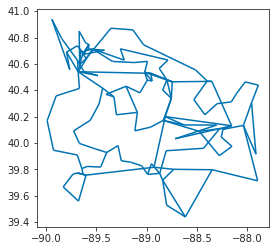

<IPython.core.display.Javascript object>

In [8]:
#####################################
##########bus_df
####################################

b_df = bus_df[["BusNum", "Latitude", "Longitude"]].set_index("BusNum").copy()
# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
bus_gdf = gpd.GeoDataFrame(
    b_df,
    geometry=gpd.points_from_xy(b_df["Longitude"], b_df["Latitude"]),
    crs="epsg:4326",
)
bus_gdf


###### OPTIONAL: make bus "sizes" reflect the number of buses at the same latlon
df = bus_gdf.copy()
df["subgraph"] = 1


df = (
    df[["Latitude", "Longitude", "subgraph"]]
    .groupby(["Latitude", "Longitude"])
    .transform("count")
)
df

bus_gdf["size"] = df["subgraph"] * 10
bus_gdf

####  unique latlons
bus_unique_gdf = bus_gdf.drop_duplicates(["Latitude", "Longitude"])
print("\nnumber of unique latlons: {} out of 2000".format(len(bus_unique_gdf)))
bus_unique_gdf


####

###########################################
############ branch_df
##############################################

br_df = branch_df[
    [
        "FromBus",
        "ToBus",
        "from_latitude",
        "from_longitude",
        "to_latitude",
        "to_longitude",
    ]
].copy()

############## make from/to Points

br_df["FromPoint"] = [
    Point(x, y) for x, y in zip(br_df["from_longitude"], br_df["from_latitude"])
]
br_df["ToPoint"] = [
    Point(x, y) for x, y in zip(br_df["to_longitude"], br_df["to_latitude"])
]


############ lines
br_df["geometry"] = [
    LineString([x1, x2]) for x1, x2 in zip(br_df["FromPoint"], br_df["ToPoint"])
]


# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
br_gdf = gpd.GeoDataFrame(br_df, geometry="geometry", crs="epsg:4326")

br_gdf.plot()

br_df


bus_gdf = bus_gdf.to_crs(epsg=3857)
br_gdf = br_gdf.to_crs(epsg=3857)



## existing wind penetration 
* using TE WTK

In [9]:
### for the true wind penetration we should get the actuals
# ##retrieve wind sites matching current wind penetration

# # retrieve wind sites (wind_sites are initially set to empty df )
# grid
# grid.retrieve_wind_sites(method="simple proximity")
# grid
# grid.wind_sites.head()


# grid.make_tables(
#     actuals_start=pd.Timestamp("2007-01-01 00:00:00", tz="utc"),
#     actuals_end=pd.Timestamp("2007-12-31 23:55:00", tz="utc"),
#     scenarios_start=pd.Timestamp("2008-01-01 00:00:00", tz="utc"),
#     scenarios_end=pd.Timestamp("2013-12-31 23:55:00", tz="utc"),
# )


tables_dir = "/projects/exasgd/isatkaus/data/tables-data/"

# read instead of retrieve_wind_sites
filename = "{}_wind_sites_df.h5".format(grid_name)
grid.wind_sites = pd.read_hdf(os.path.join(tables_dir,filename))
print("\n wind sites")
grid.wind_sites.head()

# read instead of make_tables
filename = "{}_actuals_df.h5".format(grid_name)
grid.actuals = pd.read_hdf(os.path.join(tables_dir,filename))
filename = "{}_scenarios_df.h5".format(grid_name)
grid.scenarios = pd.read_hdf(os.path.join(tables_dir,filename))


# for actuals, make year you want
grid.actuals.index = grid.actuals.index.map(lambda t: t.replace(year=2020))
# see what you got
print("\nactuals_df:")
grid.actuals.head()
print("\nscenarios_df:")
grid.scenarios.head()




 wind sites


,SiteID,Capacity,Point,Latitude,Longitude,BusNum,GenUID
0,54007,16.0,POINT (-88.02514600000001 40.458515),40.458515,-88.025146,65,65_Wind_1
1,54196,16.0,POINT (-88.02273599999999 40.476978),40.476978,-88.022736,65,65_Wind_1
2,54008,16.0,POINT (-88.000885 40.456665),40.456665,-88.000885,65,65_Wind_1
3,53833,16.0,POINT (-88.02758799999999 40.440052),40.440052,-88.027588,65,65_Wind_1
4,54197,16.0,POINT (-87.998474 40.475128),40.475128,-87.998474,65,65_Wind_1



actuals_df:


,65_Wind_1,104_Wind_1,105_Wind_1,114_Wind_1,115_Wind_1,147_Wind_1,TotalPower
IssueTime,,,,,,,
2020-01-01 00:00:00+00:00,142.094736,99.000001,198.000002,1.7,150.0,100.5,691.294739
2020-01-01 00:05:00+00:00,140.804726,99.000001,198.000002,1.7,150.0,100.5,690.004728
2020-01-01 00:10:00+00:00,142.361249,99.000001,198.000002,1.7,150.0,100.5,691.561251
2020-01-01 00:15:00+00:00,145.972502,99.000001,198.000002,1.7,150.0,100.5,695.172504
2020-01-01 00:20:00+00:00,150.399995,99.000001,198.000002,1.7,150.0,100.5,699.599997



scenarios_df:


,65_Wind_1,104_Wind_1,105_Wind_1,114_Wind_1,115_Wind_1,147_Wind_1,TotalPower,Deviation
IssueTime,,,,,,,,
2008-01-01 00:00:00+00:00,1.459344,0.668133,0.583035,-0.024500,0.877288,1.845110,96.746560,5.408411
2008-01-01 00:05:00+00:00,1.601367,-0.445220,1.269019,0.091567,1.525665,3.528319,102.154971,7.570718
2008-01-01 00:10:00+00:00,1.097983,-0.016742,1.678258,0.294259,3.257260,5.579959,109.725689,11.890977
2008-01-01 00:15:00+00:00,1.172363,2.034480,3.025435,0.001593,4.814818,3.355411,121.616666,14.404100
2008-01-01 00:20:00+00:00,1.237113,2.234493,2.933309,0.000000,5.278723,6.783124,136.020766,18.466761


<IPython.core.display.Javascript object>

In [10]:
### total available wind energy (2007) when using TE
TE_wind_energy = grid.actuals["TotalPower"].sum() / 12
TE_wind_energy

2682398.2395944702

<IPython.core.display.Javascript object>

# generator types 
* total generation capacity

In [11]:
total_all_cap = gen_df["GenMWMax"].sum()
print(f"\n total grid generation capacity: {round(total_all_cap)} MW")
for fuel_type in gen_df["GenFuelType"].unique():
    fuel_type
    df = gen_df.loc[gen_df["GenFuelType"] == fuel_type]
    total_type_cap = df["GenMWMax"].sum()

    print(
        f"\n total generation capacity for {fuel_type} is {round(total_type_cap)} MW, i.e. {round(total_type_cap/total_all_cap,2)*100}%"
    )
    df


 total grid generation capacity: 3603 MW


'Coal'


 total generation capacity for Coal is 1919 MW, i.e. 53.0%


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.530000,1.36,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.530000,1.36,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.530000,1.36,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.530000,1.36,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
34,154,1,77.219999,23.17,1.0,Coal,154_Coal_1,SPRINGFIELD55,39.757327,-89.600512,3
35,155,1,77.219999,23.17,1.0,Coal,155_Coal_1,SPRINGFIELD56,39.757327,-89.600512,3
44,182,1,17.500000,5.25,1.0,Coal,182_Coal_1,SPRINGFIELD21,39.806868,-89.641653,4
45,183,1,26.600000,7.98,1.0,Coal,183_Coal_1,SPRINGFIELD22,39.806868,-89.641653,4


'Wind'


 total generation capacity for Wind is 700 MW, i.e. 19.0%


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
5,65,1,150.399995,45.120001,1.0,Wind,65_Wind_1,PAXTON11,40.46405,-88.021517,6
21,104,1,99.000001,29.699999,1.0,Wind,104_Wind_1,ELLSWORTH12,40.47920,-88.798900,7
22,105,1,198.000002,59.400004,1.0,Wind,105_Wind_1,ELLSWORTH13,40.47920,-88.798900,7
23,114,1,1.700000,0.510000,1.0,Wind,114_Wind_1,NORMAL22,40.53700,-89.019000,7
24,115,1,150.000000,44.999999,1.0,Wind,115_Wind_1,NORMAL23,40.53700,-89.019000,7
30,147,1,100.500000,30.149999,1.0,Wind,147_Wind_1,HOPEDALE21,40.36920,-89.402200,7


'NaturalGas'


 total generation capacity for NaturalGas is 416 MW, i.e. 12.0%


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
13,76,1,4.000000,1.20,1.0,NaturalGas,76_NaturalGas_1,BRIMFIELD1,40.794200,-89.843600,2
14,77,1,2.400000,0.72,1.0,NaturalGas,77_NaturalGas_1,BRIMFIELD2,40.794200,-89.843600,2
15,78,1,18.000001,5.40,1.0,NaturalGas,78_NaturalGas_1,BRIMFIELD3,40.794200,-89.843600,2
16,79,1,18.000001,5.40,1.0,NaturalGas,79_NaturalGas_1,BRIMFIELD4,40.794200,-89.843600,2
...,...,...,...,...,...,...,...,...,...,...,...
42,169,1,9.400000,2.82,1.0,NaturalGas,169_NaturalGas_1,CHAMPAIGN16,40.105169,-88.241528,5
43,170,1,9.400000,2.82,1.0,NaturalGas,170_NaturalGas_1,CHAMPAIGN17,40.105169,-88.241528,5
47,196,1,67.500001,20.25,1.0,NaturalGas,196_NaturalGas_1,GIBSONCITY11,40.470500,-88.398700,6
48,197,1,67.500001,20.25,1.0,NaturalGas,197_NaturalGas_1,GIBSONCITY12,40.470500,-88.398700,6


'Nuclear'


 total generation capacity for Nuclear is 569 MW, i.e. 16.0%


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
46,189,1,569.150019,170.749998,1.0,Nuclear,189_Nuclear_1,CLINTON12,40.1719,-88.8339,7


<IPython.core.display.Javascript object>

#  generator connections
### good notebook to look at:
* http://localhost:8888/notebooks/projects/res/notebooks/csv2net.ipynb
* all generators are connected via transformers as new buses
* ration of continuos rating to max gen: rateA/GenMWMax
* conclusion: ranteA/GenMWMax ratio for all gens is anywhere :
* from 1.3 to 6 with one outlier of 11
* wind is 1.3


In [42]:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 500)
pd.options.display.max_colwidth
## gen schema
filename = "/home/isatkaus/projects/res/data/branch_schema.csv"
br_schema = pd.read_csv(filename, index_col=0)
br_schema
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_colwidth", 50)

500

,description,type
name,,
UID,branch index,integer
fbus,bus index of branch 'from' end,integer
tbus,bus index of branch 'to' end,integer
r,resistance (p.u.),float
x,reactance (p.u.),float
b,total line charging susceptance (p.u.),float
rateA,"MVA rating A (long term rating), set to 0 for unlimited",float
rateB,"MVA rating B (short term rating), set to 0 for unlimited",float
rateC,"MVA rating C (short term rating), set to 0 for unlimited",float


<IPython.core.display.Javascript object>

In [12]:
# ### what are the transformers that connect wind gens?
# gen_df.loc[gen_df["GenFuelType"] == "Wind"]
# wind_gen_buses = gen_df.loc[gen_df["GenFuelType"] == "Wind"]["BusNum"]
# print("\n wind generator buses:")
# wind_gen_buses

<IPython.core.display.Javascript object>

In [13]:
# ### all branches connecting wind_gens are transformers
# for bus_num in wind_gen_buses[:]:
#     print("\n bus_num = {}".format(bus_num))
#     print("\n branches connected:")
#     b_df = branch_df.loc[
#         (branch_df["FromBus"] == bus_num) | (branch_df["ToBus"] == bus_num)
#     ]
#     b_df
#     for br_idx in b_df.index:
#         if b_df.loc[br_idx, "distance"] == 0:
#             print("\n branch {} is a transformer".format(br_idx))
#         else:
#             print("\n branch {} is a NOT transformer")

<IPython.core.display.Javascript object>

In [79]:
### all branches connecting gens are transformers
## number of branches connected to a gen: can it be more than 1?
more_than_one_branch = False
gen_branch_not_trafo = False
gen_buses = gen_df["BusNum"]
for bus_num in gen_buses[:]:
    print("\n generator at bus_num = {}".format(bus_num))
    print("\n branches connected:")
    b_df = branch_df.loc[
        (branch_df["FromBus"] == bus_num) | (branch_df["ToBus"] == bus_num)
    ]
    b_df
    if len(b_df) > 1:
        more_than_one_branch = True
    for br_idx in b_df.index:
        if b_df.loc[br_idx, "distance"] == 0:
            print("\n branch {} is a transformer".format(br_idx))
        else:
            print("\n branch {} is a NOT transformer")
            gen_branch_not_trafo = True

print("\n does there exist a generator with more than one branch connected to it?")
more_than_one_branch
print("\n is there a generator that is connected by NOT a transformer (dist!=0)?")
gen_branch_not_trafo


 generator at bus_num = 49

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
77,49,48,0.027149,0.532021,0.0,28.9,0,0,1,0,1,0,0,1.36,0.88,-1.36,-0.87,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444



 branch 77 is a transformer

 generator at bus_num = 50

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
78,50,48,0.021719,0.404167,0.0,28.7,0,0,1,0,1,0,0,1.36,1.18,-1.36,-1.17,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444



 branch 78 is a transformer

 generator at bus_num = 51

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
79,51,48,0.027149,0.612711,0.0,24.3,0,0,1,0,1,0,0,1.36,0.77,-1.36,-0.75,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444



 branch 79 is a transformer

 generator at bus_num = 52

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
80,52,48,0.021719,0.379817,0.0,24.3,0,0,1,0,1,0,0,1.36,1.25,-1.36,-1.24,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444



 branch 80 is a transformer

 generator at bus_num = 53

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
81,53,48,0.02121,0.576549,0.0,35.3,0,0,1,0,1,0,0,2.72,0.79,-2.72,-0.75,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444



 branch 81 is a transformer

 generator at bus_num = 65

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
102,65,64,0.00128,0.10157,0.0,195.5,0,0,1,0,1,0,0,86.5,0.84,-86.41,6.18,0.0,0.0,0.0,0.0,0.0,40.46405,-88.021517,40.46405,-88.021517



 branch 102 is a transformer

 generator at bus_num = 67

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
103,67,66,0.020951,0.144786,0.0,30.0,0,0,1,0,1,0,0,1.41,-0.57,-1.41,0.57,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 103 is a transformer

 generator at bus_num = 68

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
104,68,66,0.00689,0.264997,0.0,73.0,0,0,1,0,1,0,0,8.38,-0.55,-8.38,0.72,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 104 is a transformer

 generator at bus_num = 69

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
105,69,66,0.00441,0.09499,0.0,70.5,0,0,1,0,1,0,0,8.38,-1.53,-8.38,1.59,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 105 is a transformer

 generator at bus_num = 70

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
106,70,66,0.00689,0.199449,0.0,70.5,0,0,1,0,1,0,0,8.38,-0.78,-8.38,0.91,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 106 is a transformer

 generator at bus_num = 71

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
107,71,66,0.003528,0.081544,0.0,68.0,0,0,1,0,1,0,0,8.38,-1.7,-8.38,1.76,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 107 is a transformer

 generator at bus_num = 72

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
108,72,66,0.003528,0.074599,0.0,68.0,0,0,1,0,1,0,0,8.38,-1.86,-8.38,1.91,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 108 is a transformer

 generator at bus_num = 73

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
109,73,66,0.00689,0.146423,0.0,65.0,0,0,1,0,1,0,0,8.38,-1.11,-8.38,1.2,0.0,0.0,0.0,0.0,0.0,39.7703,-88.8697,39.7703,-88.8697



 branch 109 is a transformer

 generator at bus_num = 76

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
112,76,75,0.038464,0.784328,0.0,24.3,0,0,1,0,1,0,0,1.2,1.41,-1.2,-1.38,0.0,0.0,0.0,0.0,0.0,40.7942,-89.8436,40.7942,-89.8436



 branch 112 is a transformer

 generator at bus_num = 77

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
113,77,75,0.08013,2.192105,0.0,7.4,0,0,1,0,1,0,0,0.72,0.5,-0.72,-0.49,0.0,0.0,0.0,0.0,0.0,40.7942,-89.8436,40.7942,-89.8436



 branch 113 is a transformer

 generator at bus_num = 78

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
114,78,75,0.008544,0.181406,0.0,65.0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.7942,-89.8436,40.7942,-89.8436



 branch 114 is a transformer

 generator at bus_num = 79

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
115,79,75,0.01068,0.277774,0.0,62.1,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.7942,-89.8436,40.7942,-89.8436



 branch 115 is a transformer

 generator at bus_num = 90

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
135,90,89,0.0601,2.279922,0.0,8.6,0,0,1,0,1,0,0,0.96,0.13,-0.96,-0.11,0.0,0.0,0.0,0.0,0.0,40.120833,-88.961111,40.120833,-88.961111



 branch 135 is a transformer

 generator at bus_num = 91

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
136,91,89,0.024614,0.503424,0.0,32.0,0,0,1,0,1,0,0,1.5,0.59,-1.5,-0.58,0.0,0.0,0.0,0.0,0.0,40.120833,-88.961111,40.120833,-88.961111



 branch 136 is a transformer

 generator at bus_num = 92

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
137,92,89,0.019539,0.36204,0.0,35.3,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.120833,-88.961111,40.120833,-88.961111



 branch 137 is a transformer

 generator at bus_num = 94

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
140,94,93,0.01068,0.280602,0.0,62.1,0,0,1,0,1,0,0,5.4,-2.2,-5.4,2.29,0.0,0.0,0.0,0.0,0.0,39.798175,-88.349771,39.798175,-88.349771



 branch 140 is a transformer

 generator at bus_num = 104

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
156,104,102,0.0021,0.087749,0.0,130.0,0,0,1,0,1,0,0,67.6,3.1,-67.51,0.62,0.0,0.0,0.0,0.0,0.0,40.4792,-88.7989,40.4792,-88.7989



 branch 156 is a transformer

 generator at bus_num = 105

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
157,105,102,0.00097,0.059419,0.0,260.0,0,0,1,0,1,0,0,154.8,8.29,-154.58,4.91,0.0,0.0,0.0,0.0,0.0,40.4792,-88.7989,40.4792,-88.7989



 branch 157 is a transformer

 generator at bus_num = 114

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
170,114,112,0.06,0.434013,0.0,20.0,0,0,1,0,1,0,0,1.4,0.36,-1.4,-0.35,0.0,0.0,0.0,0.0,0.0,40.537,-89.019,40.537,-89.019



 branch 170 is a transformer

 generator at bus_num = 115

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
171,115,112,0.00128,0.062771,0.0,200.0,0,0,1,0,1,0,0,133.5,12.6,-133.29,-2.16,0.0,0.0,0.0,0.0,0.0,40.537,-89.019,40.537,-89.019



 branch 171 is a transformer

 generator at bus_num = 125

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
185,125,123,0.00448,0.104562,0.0,170.0,0,0,1,0,1,0,0,39.02,7.24,-38.95,-5.72,0.0,0.0,0.0,0.0,0.0,40.5958,-89.6631,40.5958,-89.6631



 branch 185 is a transformer

 generator at bus_num = 126

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
186,126,123,0.00148,0.066043,0.0,170.0,0,0,1,0,1,0,0,39.02,12.55,-39.0,-11.52,0.0,0.0,0.0,0.0,0.0,40.5958,-89.6631,40.5958,-89.6631



 branch 186 is a transformer

 generator at bus_num = 127

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
187,127,123,0.001,0.031691,0.0,170.0,0,0,1,0,1,0,0,39.02,25.99,-39.0,-25.35,0.0,0.0,0.0,0.0,0.0,40.5958,-89.6631,40.5958,-89.6631



 branch 187 is a transformer

 generator at bus_num = 135

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
195,135,133,0.00043,0.033512,0.0,580.0,0,0,1,0,1,0,0,133.92,21.46,-133.85,-15.76,0.0,0.0,0.0,0.0,0.0,40.5408,-89.6786,40.5408,-89.6786



 branch 195 is a transformer

 generator at bus_num = 136

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
196,136,133,0.00043,0.027478,0.0,580.0,0,0,1,0,1,0,0,133.92,25.06,-133.85,-20.34,0.0,0.0,0.0,0.0,0.0,40.5408,-89.6786,40.5408,-89.6786



 branch 196 is a transformer

 generator at bus_num = 147

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
207,147,146,0.0025,0.10181,0.0,130.6,0,0,1,0,1,0,0,92.4,8.79,-92.2,-0.69,0.0,0.0,0.0,0.0,0.0,40.3692,-89.4022,40.3692,-89.4022



 branch 207 is a transformer

 generator at bus_num = 151

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
210,151,149,0.02267,0.625521,0.0,20.0,0,0,1,0,1,0,0,1.62,0.02,-1.62,-0.01,0.0,0.0,0.0,0.0,0.0,39.757327,-89.600512,39.757327,-89.600512



 branch 210 is a transformer

 generator at bus_num = 152

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
211,152,149,0.00249,0.141687,0.0,100.0,0,0,1,0,1,0,0,23.17,0.27,-23.16,0.43,0.0,0.0,0.0,0.0,0.0,39.757327,-89.600512,39.757327,-89.600512



 branch 211 is a transformer

 generator at bus_num = 153

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
212,153,149,0.00549,0.184603,0.0,100.0,0,0,1,0,1,0,0,23.17,0.02,-23.14,0.9,0.0,0.0,0.0,0.0,0.0,39.757327,-89.600512,39.757327,-89.600512



 branch 212 is a transformer

 generator at bus_num = 154

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
213,154,149,0.00249,0.10294,0.0,100.0,0,0,1,0,1,0,0,23.17,0.14,-23.16,0.37,0.0,0.0,0.0,0.0,0.0,39.757327,-89.600512,39.757327,-89.600512



 branch 213 is a transformer

 generator at bus_num = 155

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
214,155,149,0.00249,0.099835,0.0,100.0,0,0,1,0,1,0,0,23.17,0.13,-23.16,0.36,0.0,0.0,0.0,0.0,0.0,39.757327,-89.600512,39.757327,-89.600512



 branch 214 is a transformer

 generator at bus_num = 161

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
218,161,160,0.00139,0.080288,0.0,180.2,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.8233,-89.5891,39.8233,-89.5891



 branch 218 is a transformer

 generator at bus_num = 164

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
220,164,163,0.008207,0.11301,0.0,58.1,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 220 is a transformer

 generator at bus_num = 165

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
221,165,163,0.0074,0.301657,0.0,65.0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 221 is a transformer

 generator at bus_num = 166

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
222,166,163,0.016368,0.382075,0.0,42.0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 222 is a transformer

 generator at bus_num = 167

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
223,167,163,0.010476,0.196499,0.0,42.0,0,0,1,0,1,0,0,2.82,-1.04,-2.82,1.06,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 223 is a transformer

 generator at bus_num = 168

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
224,168,163,0.018,0.490983,0.0,40.0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 224 is a transformer

 generator at bus_num = 169

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
225,169,163,0.016368,0.396417,0.0,40.0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 225 is a transformer

 generator at bus_num = 170

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
226,170,163,0.016368,0.374902,0.0,35.6,0,0,1,0,1,0,0,2.82,-0.99,-2.82,1.02,0.0,0.0,0.0,0.0,0.0,40.105169,-88.241528,40.105169,-88.241528



 branch 226 is a transformer

 generator at bus_num = 182

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
238,182,181,0.01099,0.297746,0.0,60.3,0,0,1,0,1,0,0,5.25,2.15,-5.25,-2.06,0.0,0.0,0.0,0.0,0.0,39.806868,-89.641653,39.806868,-89.641653



 branch 238 is a transformer

 generator at bus_num = 183

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
239,183,181,0.004627,0.114254,0.0,65.0,0,0,1,0,1,0,0,7.98,5.73,-7.98,-5.62,0.0,0.0,0.0,0.0,0.0,39.806868,-89.641653,39.806868,-89.641653



 branch 239 is a transformer

 generator at bus_num = 189

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
242,189,187,0.0003,0.007815,0.0,740.0,0,0,1,0,1,0,0,384.37,-24.15,-383.96,34.87,0.0,0.0,0.0,0.0,0.0,40.1719,-88.8339,40.1719,-88.8339



 branch 242 is a transformer

 generator at bus_num = 196

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
243,196,195,0.00285,0.060038,0.0,87.7,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.4705,-88.3987,40.4705,-88.3987



 branch 243 is a transformer

 generator at bus_num = 197

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
244,197,195,0.00285,0.191484,0.0,87.7,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.4705,-88.3987,40.4705,-88.3987



 branch 244 is a transformer

 does there exist a generator with more than one branch connected to it?


False


 is there a generator that is connected by NOT a transformer (dist!=0)?


False

<IPython.core.display.Javascript object>

# wind gen branches

In [80]:
### what are the transformers that connect wind gens?
print("\n wind generators")
gen_df.loc[gen_df["GenFuelType"] == "Wind"]
wind_gen_buses = gen_df.loc[gen_df["GenFuelType"] == "Wind"]["BusNum"]
# print("\n wind generator buses:")
# wind_gen_buses

### how does wind gen capacity correlates to rateA of the generator
g_df = gen_df.loc[gen_df["GenFuelType"] == "Wind"]

b_df = branch_df.loc[
    (branch_df["FromBus"].isin(wind_gen_buses))
    | (branch_df["ToBus"].isin(wind_gen_buses))
]
print("\n branches (transformers) connecting wind generators:")
b_df

trans_df = b_df[["FromBus", "ToBus", "r", "x", "b", "rateA"]]
trans_df["UID"] = trans_df.index
df = trans_df.set_index("FromBus")
df["GenMWMax"] = g_df.set_index("BusNum")["GenMWMax"]
df["GenMWMin"] = g_df.set_index("BusNum")["GenMWMin"]
trans_df = df
trans_df["FromBus"] = trans_df.index
trans_df = trans_df.set_index("UID")

print("\n transformers connecting wind gens with gen min/max capacities:")
# a = trans_df.columns[:-1].tolist()
# b = trans_df.columns[-1:].tolist()
# trans_df = trans_df[b + a]
trans_df


 wind generators


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
5,65,1,150.399995,45.120001,1.0,Wind,65_Wind_1,PAXTON11,40.46405,-88.021517,6
21,104,1,99.000001,29.699999,1.0,Wind,104_Wind_1,ELLSWORTH12,40.47920,-88.798900,7
22,105,1,198.000002,59.400004,1.0,Wind,105_Wind_1,ELLSWORTH13,40.47920,-88.798900,7
23,114,1,1.700000,0.510000,1.0,Wind,114_Wind_1,NORMAL22,40.53700,-89.019000,7
24,115,1,150.000000,44.999999,1.0,Wind,115_Wind_1,NORMAL23,40.53700,-89.019000,7
30,147,1,100.500000,30.149999,1.0,Wind,147_Wind_1,HOPEDALE21,40.36920,-89.402200,7



 branches (transformers) connecting wind generators:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
102,65,64,0.00128,0.101570,0.0,195.5,0,0,1,0,1,0,0,86.5,0.84,-86.41,6.18,0.0,0.0,0.0,0.0,0.0,40.46405,-88.021517,40.46405,-88.021517
156,104,102,0.00210,0.087749,0.0,130.0,0,0,1,0,1,0,0,67.6,3.10,-67.51,0.62,0.0,0.0,0.0,0.0,0.0,40.47920,-88.798900,40.47920,-88.798900
157,105,102,0.00097,0.059419,0.0,260.0,0,0,1,0,1,0,0,154.8,8.29,-154.58,4.91,0.0,0.0,0.0,0.0,0.0,40.47920,-88.798900,40.47920,-88.798900
170,114,112,0.06000,0.434013,0.0,20.0,0,0,1,0,1,0,0,1.4,0.36,-1.40,-0.35,0.0,0.0,0.0,0.0,0.0,40.53700,-89.019000,40.53700,-89.019000
171,115,112,0.00128,0.062771,0.0,200.0,0,0,1,0,1,0,0,133.5,12.60,-133.29,-2.16,0.0,0.0,0.0,0.0,0.0,40.53700,-89.019000,40.53700,-89.019000
207,147,146,0.00250,0.101810,0.0,130.6,0,0,1,0,1,0,0,92.4,8.79,-92.20,-0.69,0.0,0.0,0.0,0.0,0.0,40.36920,-89.402200,40.36920,-89.402200



 transformers connecting wind gens with gen min/max capacities:


,ToBus,r,x,b,rateA,GenMWMax,GenMWMin,FromBus
UID,,,,,,,,
102,64,0.00128,0.101570,0.0,195.5,150.399995,45.120001,65
156,102,0.00210,0.087749,0.0,130.0,99.000001,29.699999,104
157,102,0.00097,0.059419,0.0,260.0,198.000002,59.400004,105
170,112,0.06000,0.434013,0.0,20.0,1.700000,0.510000,114
171,112,0.00128,0.062771,0.0,200.0,150.000000,44.999999,115
207,146,0.00250,0.101810,0.0,130.6,100.500000,30.149999,147


<IPython.core.display.Javascript object>

In [81]:
### drop branch 170 since it's gen is an outlier: 1.7 MW wind farm
trans_df.drop(170, inplace=True)

<IPython.core.display.Javascript object>

In [92]:
# trans_df["rateA"] / trans_df["GenMWMax"]
param="rateA"
ratio_min = round((trans_df[param] / trans_df["GenMWMax"]).min(),4)
ratio_max = round((trans_df[param] / trans_df["GenMWMax"]).max(),4)
print(f"\n wind gen ratio {param}/GenMWMax interval: [{ratio_min},{ratio_max }]")
title = f"wind generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)

param="r"
ratio_min = round((trans_df[param] / trans_df["GenMWMax"]).min(),8)
ratio_max = round((trans_df[param] / trans_df["GenMWMax"]).max(),8)
print(f"\n wind gen ratio {param}/GenMWMax interval: [{ratio_min},{ratio_max }]")
title = f"generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)

param="x"
ratio_min = round((trans_df[param] / trans_df["GenMWMax"]).min(),8)
ratio_max = round((trans_df[param] / trans_df["GenMWMax"]).max(),8)
print(f"\n wind gen ratio {param}/GenMWMax interval: [{ratio_min},{ratio_max }]")
title = f"generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)



 wind gen ratio rateA/GenMWMax interval: [1.2995,1.3333]



 wind gen ratio r/GenMWMax interval: [4.9e-06,2.488e-05]



 wind gen ratio x/GenMWMax interval: [0.0003001,0.00101303]


<IPython.core.display.Javascript object>

In [95]:
np.random.uniform(low=1.3, high=1.3333, size=1)[0]

1.3088416958679425

<IPython.core.display.Javascript object>

# all generators

In [66]:
gen_df

,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.530000,1.360000,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.530000,1.360000,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.530000,1.360000,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.530000,1.360000,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
4,53,1,9.070000,2.720000,1.0,Coal,53_Coal_1,RANTOUL25,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
44,182,1,17.500000,5.250000,1.0,Coal,182_Coal_1,SPRINGFIELD21,39.806868,-89.641653,4
45,183,1,26.600000,7.980000,1.0,Coal,183_Coal_1,SPRINGFIELD22,39.806868,-89.641653,4
46,189,1,569.150019,170.749998,1.0,Nuclear,189_Nuclear_1,CLINTON12,40.171900,-88.833900,7
47,196,1,67.500001,20.250000,1.0,NaturalGas,196_NaturalGas_1,GIBSONCITY11,40.470500,-88.398700,6


<IPython.core.display.Javascript object>

In [69]:
### how does gen capacity correlates to rateA of the generator
g_df = gen_df
# g_df
b_df = branch_df.loc[
    (branch_df["FromBus"].isin(gen_buses)) | (branch_df["ToBus"].isin(gen_buses))
]
# b_df
trans_df = b_df[["FromBus", "ToBus", "r", "x", "b", "rateA"]]
trans_df["UID"] = trans_df.index
df = trans_df.set_index("FromBus")
df["GenMWMax"] = g_df.set_index("BusNum")["GenMWMax"]
df["GenMWMin"] = g_df.set_index("BusNum")["GenMWMin"]
df["GenFuelType"] = g_df.set_index("BusNum")["GenFuelType"]
trans_df = df
trans_df["FromBus"] = trans_df.index
trans_df = trans_df.set_index("UID")
print("\n transformers connecting gens with gen min/max capacities:")
trans_df


 transformers connecting gens with gen min/max capacities:


,ToBus,r,x,b,rateA,GenMWMax,GenMWMin,GenFuelType,FromBus
UID,,,,,,,,,
77,48,0.027149,0.532021,0.0,28.9,4.530000,1.360000,Coal,49
78,48,0.021719,0.404167,0.0,28.7,4.530000,1.360000,Coal,50
79,48,0.027149,0.612711,0.0,24.3,4.530000,1.360000,Coal,51
80,48,0.021719,0.379817,0.0,24.3,4.530000,1.360000,Coal,52
81,48,0.021210,0.576549,0.0,35.3,9.070000,2.720000,Coal,53
...,...,...,...,...,...,...,...,...,...
238,181,0.010990,0.297746,0.0,60.3,17.500000,5.250000,Coal,182
239,181,0.004627,0.114254,0.0,65.0,26.600000,7.980000,Coal,183
242,187,0.000300,0.007815,0.0,740.0,569.150019,170.749998,Nuclear,189


<IPython.core.display.Javascript object>

In [72]:
### all trafos connecting gens have zero "b"?
print("\n all trafos connecting gens have zero 'b' parameter?")
(trans_df["b"] == 0).all()


 all trafos connecting gens have zero 'b' parameter?


True

<IPython.core.display.Javascript object>

In [78]:
# trans_df["rateA"] / trans_df["GenMWMax"]
param="rateA"
ratio_min = (trans_df[param] / trans_df["GenMWMax"]).min()
ratio_max = (trans_df[param] / trans_df["GenMWMax"]).max()
print(f"\n ratio interval: [{ratio_min},{ratio_max }]")
title = f"generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)

param="r"
ratio_min = (trans_df[param] / trans_df["GenMWMax"]).min()
ratio_max = (trans_df[param] / trans_df["GenMWMax"]).max()
print(f"\n ratio interval: [{ratio_min},{ratio_max }]")
title = f"generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)

param="x"
ratio_min = (trans_df[param] / trans_df["GenMWMax"]).min()
ratio_max = (trans_df[param] / trans_df["GenMWMax"]).max()
print(f"\n ratio interval: [{ratio_min},{ratio_max }]")
title = f"generator {param}/GenMWMax ratio"
(trans_df[param] / trans_df["GenMWMax"]).reset_index(drop=True).iplot(
    kind="bar", title=title
)



 ratio interval: [1.1333333333333333,11.764705242995195]



 ratio interval: [5.271018011902035e-07,0.03529411572898558]



 ratio interval: [1.3731001921004806e-05,0.9133770753939456]


<IPython.core.display.Javascript object>

## by fuel type

In [74]:
for fuel_type in trans_df["GenFuelType"].unique():
    fuel_type
    df = trans_df.loc[trans_df["GenFuelType"] == fuel_type]
    (df["rateA"] / df["GenMWMax"]).reset_index(drop=True).iplot(
        kind="bar", title=fuel_type + ": rateA/GenMWMax"
    )
    # df[["x", "r", "rateA", "GenMWMax"]].reset_index(drop=True).iplot(kind="bar")

'Coal'

'Wind'

'NaturalGas'

'Nuclear'

<IPython.core.display.Javascript object>

In [20]:
trans_df

,ToBus,r,x,b,rateA,GenMWMax,GenMWMin,GenFuelType,FromBus
UID,,,,,,,,,
77,48,0.027149,0.532021,0.0,28.9,4.530000,1.360000,Coal,49
78,48,0.021719,0.404167,0.0,28.7,4.530000,1.360000,Coal,50
79,48,0.027149,0.612711,0.0,24.3,4.530000,1.360000,Coal,51
80,48,0.021719,0.379817,0.0,24.3,4.530000,1.360000,Coal,52
...,...,...,...,...,...,...,...,...,...
239,181,0.004627,0.114254,0.0,65.0,26.600000,7.980000,Coal,183
242,187,0.000300,0.007815,0.0,740.0,569.150019,170.749998,Nuclear,189
243,195,0.002850,0.060038,0.0,87.7,67.500001,20.250000,NaturalGas,196
244,195,0.002850,0.191484,0.0,87.7,67.500001,20.250000,NaturalGas,197


<IPython.core.display.Javascript object>

In [21]:
############################################
#### generator capacities by type
for fuel_type in trans_df["GenFuelType"].unique():
    fuel_type
    df = trans_df.loc[trans_df["GenFuelType"] == fuel_type]
    (df["GenMWMax"]).reset_index(drop=True).iplot(
        kind="hist",
        title=fuel_type + " GenMWMax histogram",
        bins=50,
    )

'Coal'

'Wind'

'NaturalGas'

'Nuclear'

<IPython.core.display.Javascript object>

In [22]:
df = gen_df.loc[gen_df["GenMWMax"] < 5]
df
branch_df.loc[branch_df["FromBus"].isin(df["BusNum"])]
branch_df.loc[branch_df["ToBus"].isin(df["BusNum"])]

### are all gen buses "From" buses?
print("\n From")
branch_df.loc[branch_df["FromBus"].isin(gen_df["BusNum"])]
print("\n To")
branch_df.loc[branch_df["ToBus"].isin(gen_df["BusNum"])]


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.53,1.36,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.53,1.36,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.53,1.36,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.53,1.36,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
13,76,1,4.00,1.20,1.0,NaturalGas,76_NaturalGas_1,BRIMFIELD1,40.794200,-89.843600,2
14,77,1,2.40,0.72,1.0,NaturalGas,77_NaturalGas_1,BRIMFIELD2,40.794200,-89.843600,2
17,90,1,3.20,0.96,1.0,NaturalGas,90_NaturalGas_1,CLINTON31,40.120833,-88.961111,7
23,114,1,1.70,0.51,1.0,Wind,114_Wind_1,NORMAL22,40.537000,-89.019000,7


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
77,49,48,0.027149,0.532021,0.0,28.9,0,0,1,0,1,0,0,1.36,0.88,-1.36,-0.87,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
78,50,48,0.021719,0.404167,0.0,28.7,0,0,1,0,1,0,0,1.36,1.18,-1.36,-1.17,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
79,51,48,0.027149,0.612711,0.0,24.3,0,0,1,0,1,0,0,1.36,0.77,-1.36,-0.75,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
80,52,48,0.021719,0.379817,0.0,24.3,0,0,1,0,1,0,0,1.36,1.25,-1.36,-1.24,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,76,75,0.038464,0.784328,0.0,24.3,0,0,1,0,1,0,0,1.20,1.41,-1.20,-1.38,0.0,0.0,0.0,0.0,0.0,40.794200,-89.843600,40.794200,-89.843600
113,77,75,0.080130,2.192105,0.0,7.4,0,0,1,0,1,0,0,0.72,0.50,-0.72,-0.49,0.0,0.0,0.0,0.0,0.0,40.794200,-89.843600,40.794200,-89.843600
135,90,89,0.060100,2.279922,0.0,8.6,0,0,1,0,1,0,0,0.96,0.13,-0.96,-0.11,0.0,0.0,0.0,0.0,0.0,40.120833,-88.961111,40.120833,-88.961111
170,114,112,0.060000,0.434013,0.0,20.0,0,0,1,0,1,0,0,1.40,0.36,-1.40,-0.35,0.0,0.0,0.0,0.0,0.0,40.537000,-89.019000,40.537000,-89.019000


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,



 From


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
77,49,48,0.027149,0.532021,0.0,28.9,0,0,1,0,1,0,0,1.36,0.88,-1.36,-0.87,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
78,50,48,0.021719,0.404167,0.0,28.7,0,0,1,0,1,0,0,1.36,1.18,-1.36,-1.17,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
79,51,48,0.027149,0.612711,0.0,24.3,0,0,1,0,1,0,0,1.36,0.77,-1.36,-0.75,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
80,52,48,0.021719,0.379817,0.0,24.3,0,0,1,0,1,0,0,1.36,1.25,-1.36,-1.24,0.0,0.0,0.0,0.0,0.0,40.312222,-88.159444,40.312222,-88.159444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,183,181,0.004627,0.114254,0.0,65.0,0,0,1,0,1,0,0,7.98,5.73,-7.98,-5.62,0.0,0.0,0.0,0.0,0.0,39.806868,-89.641653,39.806868,-89.641653
242,189,187,0.000300,0.007815,0.0,740.0,0,0,1,0,1,0,0,384.37,-24.15,-383.96,34.87,0.0,0.0,0.0,0.0,0.0,40.171900,-88.833900,40.171900,-88.833900
243,196,195,0.002850,0.060038,0.0,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,40.470500,-88.398700,40.470500,-88.398700
244,197,195,0.002850,0.191484,0.0,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,40.470500,-88.398700,40.470500,-88.398700



 To


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

## load connections

In [23]:
load_data_dir = "/projects/exasgd/isatkaus/data/load-data/ACTIVSg200"
filename = "ACTIVSg200_loadP.csv"
loadP_df = pd.read_csv(
    os.path.join(load_data_dir, filename), index_col=0, parse_dates=True
)
loadP_df.columns = loadP_df.columns.astype("int")
loadP_df

,2,8,10,30,43,59,60,75,84,86,97,99,101,108,110,...,143,163,172,173,174,175,179,180,184,191,88,145,176,185,194
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+00:00,4.544305,14.598349,26.245053,36.335993,1.285196,2.908601,2.336720,2.213735,2.305973,5.073142,4.507410,7.483653,0.319762,5.792605,6.678099,...,14.888107,25.462109,2.990964,4.842248,1.539957,4.063931,13.125773,4.302985,5.943012,4.019455,32.817472,11.666365,12.644105,7.176744,24.988902
2017-01-01 00:05:00+00:00,4.512747,14.496972,26.062796,36.083660,1.276271,2.888403,2.320493,2.198361,2.289960,5.037912,4.476108,7.431683,0.317541,5.752379,6.631724,...,14.782036,25.280703,2.969655,4.807749,1.528986,4.034977,13.032258,4.272328,5.900671,3.990818,32.508339,11.556471,12.525000,7.109140,24.753512
2017-01-01 00:10:00+00:00,4.481190,14.395595,25.880538,35.831326,1.267346,2.868204,2.304265,2.182988,2.273946,5.002681,4.444807,7.379713,0.315321,5.712153,6.585348,...,14.675964,25.099297,2.948345,4.773251,1.518014,4.006023,12.938742,4.241672,5.858329,3.962182,32.199205,11.446576,12.405896,7.041537,24.518122
2017-01-01 00:15:00+00:00,4.449632,14.294217,25.698281,35.578993,1.258421,2.848005,2.288038,2.167615,2.257932,4.967451,4.413505,7.327743,0.313100,5.671926,6.538972,...,14.569893,24.917891,2.927036,4.738752,1.507043,3.977069,12.845227,4.211015,5.815988,3.933545,31.890071,11.336681,12.286791,6.973933,24.282732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 22:45:00+00:00,4.927676,15.829908,28.459161,39.401402,1.393619,3.153979,2.533852,2.400492,2.500512,5.501127,4.887668,8.114995,0.346738,6.281286,7.241483,...,15.240287,26.064419,3.061716,4.956792,1.576385,4.160063,13.436265,4.404773,6.083595,4.114536,33.796079,12.014253,13.021149,7.390752,25.734064
2017-12-31 22:50:00+00:00,4.912906,15.782461,28.373861,39.283304,1.389442,3.144526,2.526258,2.393297,2.493017,5.484638,4.873018,8.090672,0.345698,6.262459,7.219778,...,15.213471,26.018558,3.056328,4.948071,1.573611,4.152744,13.412623,4.397023,6.072891,4.107296,33.705046,11.981891,12.986075,7.370844,25.664746
2017-12-31 22:55:00+00:00,4.898136,15.735014,28.288560,39.165206,1.385265,3.135072,2.518663,2.386102,2.485522,5.468149,4.858368,8.066349,0.344659,6.243633,7.198073,...,15.186656,25.972697,3.050941,4.939349,1.570838,4.145424,13.388982,4.389272,6.062186,4.100057,33.614013,11.949530,12.951001,7.350936,25.595429
2017-12-31 23:00:00+00:00,4.883367,15.687567,28.203259,39.047109,1.381087,3.125619,2.511068,2.378907,2.478028,5.451661,4.843718,8.042026,0.343620,6.224806,7.176368,...,15.159840,25.926836,3.045554,4.930628,1.568064,4.138104,13.365340,4.381522,6.051482,4.092817,33.522980,11.917168,12.915927,7.331029,25.526112


<IPython.core.display.Javascript object>

In [24]:
total_loadP = loadP_df.sum().sum() / 12
print(f"\n total {grid_name} loadP: {round(total_loadP):,} MWh")

load_buses = loadP_df.columns
print(f"\n total number of load buses is {len(load_buses)} out of {len(bus_df)}")
print("\n load bus numbers:")
load_buses


 total ACTIVSg200 loadP: 8,948,357 MWh

 total number of load buses is 108 out of 200

 load bus numbers:


Int64Index([  2,   8,  10,  30,  43,  59,  60,  75,  84,  86,
            ...
            175, 179, 180, 184, 191,  88, 145, 176, 185, 194],
           dtype='int64', length=108)

<IPython.core.display.Javascript object>

In [25]:
### all branches connecting load are transformers?
## number of branches connected to a gen: can it be more than 1?
more_than_one_branch = False
load_branch_not_trafo = False
# gen_buses = gen_df["BusNum"]

for bus_num in load_buses[:]:
    print("\n load at bus_num = {}".format(bus_num))
    print("\n branches connected:")
    b_df = branch_df.loc[
        (branch_df["FromBus"] == bus_num) | (branch_df["ToBus"] == bus_num)
    ]
    b_df
    if len(b_df) > 1:
        more_than_one_branch = True
    for br_idx in b_df.index:
        if b_df.loc[br_idx, "distance"] == 0:
            print(f"\n branch {br_idx} is a transformer")
        else:
            print(f"\n branch {br_idx} is a NOT transformer")
            load_branch_not_trafo = True

print("\n does there exist a load with more than one branch connected to it?")
more_than_one_branch
print("\n is there a load that is connected by NOT a transformer (dist!=0)?")
load_branch_not_trafo


 load at bus_num = 2

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,1,0.000673,0.003339,0.0,100.0,0,0,0,0,1,0,0,-7.39,-2.1,7.39,2.11,0.0,0.0,0.0,0.0,0.0,40.642116,-89.59956,40.642116,-89.59956



 branch 0 is a transformer

 load at bus_num = 8

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
10,8,7,0.000634,0.003189,0.0,100.0,0,0,0,0,1,0,0,-23.74,-6.77,23.74,6.78,0.0,0.0,0.0,0.0,0.0,40.712882,-89.576722,40.712882,-89.576722



 branch 10 is a transformer

 load at bus_num = 10

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
14,10,9,0.000585,0.003967,0.0,100.0,0,0,0,0,1,0,0,-42.68,-12.16,42.69,12.24,0.0,0.0,0.0,0.0,0.0,40.705729,-89.653624,40.705729,-89.653624



 branch 14 is a transformer

 load at bus_num = 30

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
44,30,29,0.000694,0.003131,0.0,100.0,0,0,0,0,1,0,0,-59.09,-16.84,59.11,16.95,0.0,0.0,0.0,0.0,0.0,40.539343,-89.61832,40.539343,-89.61832



 branch 44 is a transformer

 load at bus_num = 43

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
66,43,84,0.007509,0.051295,0.00873,221.1,0,0,0,0,1,0,0,-20.04,-1.46,20.07,0.75,0.0,0.0,0.0,0.0,11.153815,40.610446,-89.122717,40.619486,-88.991155
67,43,132,0.011052,0.075503,0.01285,221.1,0,0,0,0,1,0,0,17.95,0.86,-17.92,-1.95,0.0,0.0,0.0,0.0,18.108664,40.610446,-89.122717,40.618858,-89.336899



 branch 66 is a NOT transformer

 branch 67 is a NOT transformer

 load at bus_num = 59

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
93,59,119,0.011209,0.072397,0.01381,221.1,0,0,0,0,1,0,0,5.34,1.97,-5.33,-3.38,0.0,0.0,0.0,0.0,18.416152,40.858083,-89.135201,40.870710,-89.353494
94,59,139,0.009665,0.062426,0.01191,221.1,0,0,0,0,1,0,0,-10.07,-3.32,10.08,2.15,0.0,0.0,0.0,0.0,15.386253,40.858083,-89.135201,40.744984,-89.029986



 branch 93 is a NOT transformer

 branch 94 is a NOT transformer

 load at bus_num = 60

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
95,60,97,0.012274,0.079279,0.01512,221.1,0,0,0,0,1,0,0,34.99,-2.53,-34.85,1.85,0.0,0.0,0.0,0.0,20.507159,40.414441,-89.666079,40.358139,-89.896566
96,134,60,0.009007,0.062749,0.01026,221.1,0,0,0,0,1,0,0,38.92,-1.64,-38.79,1.45,0.0,0.0,0.0,0.0,14.094759,40.540800,-89.678600,40.414441,-89.666079



 branch 95 is a NOT transformer

 branch 96 is a NOT transformer

 load at bus_num = 75

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
112,76,75,0.038464,0.784328,0.00000,24.3,0,0,1,0,1,0,0,1.20,1.41,-1.20,-1.38,0.0,0.0,0.0,0.0,0.000000,40.794200,-89.843600,40.794200,-89.843600
113,77,75,0.080130,2.192105,0.00000,7.4,0,0,1,0,1,0,0,0.72,0.50,-0.72,-0.49,0.0,0.0,0.0,0.0,0.000000,40.794200,-89.843600,40.794200,-89.843600
114,78,75,0.008544,0.181406,0.00000,65.0,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.794200,-89.843600,40.794200,-89.843600
115,79,75,0.010680,0.277774,0.00000,62.1,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.794200,-89.843600,40.794200,-89.843600
116,108,75,0.010988,0.070969,0.01354,221.1,0,0,0,0,1,0,0,-12.61,-2.57,12.63,1.25,0.0,0.0,0.0,0.0,17.982311,40.938697,-89.939478,40.794200,-89.843600
117,75,157,0.013487,0.087112,0.01662,221.1,0,0,0,0,1,0,0,-14.31,-0.40,14.34,-1.19,0.0,0.0,0.0,0.0,22.887327,40.794200,-89.843600,40.627135,-89.685132



 branch 112 is a transformer

 branch 113 is a transformer

 branch 114 is a transformer

 branch 115 is a transformer

 branch 116 is a NOT transformer

 branch 117 is a NOT transformer

 load at bus_num = 84

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
66,43,84,0.007509,0.051295,0.00873,221.1,0,0,0,0,1,0,0,-20.04,-1.46,20.07,0.75,0.0,0.0,0.0,0.0,11.153815,40.610446,-89.122717,40.619486,-88.991155
125,84,113,0.006652,0.045440,0.00773,221.1,0,0,0,0,1,0,0,-23.82,-1.82,23.86,1.27,0.0,0.0,0.0,0.0,9.471670,40.619486,-88.991155,40.537000,-89.019000



 branch 66 is a NOT transformer

 branch 125 is a NOT transformer

 load at bus_num = 86

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
11,7,86,0.003756,0.024259,0.00463,221.1,0,0,0,0,1,0,0,-12.29,-3.29,12.29,2.86,0.0,0.0,0.0,0.0,3.788746,40.712882,-89.576722,40.746726,-89.571641
127,86,101,0.005120,0.033072,0.00631,221.1,0,0,0,0,1,0,0,-8.26,-2.26,8.27,1.64,0.0,0.0,0.0,0.0,6.466530,40.746726,-89.571641,40.697618,-89.612699
128,142,86,0.003387,0.023141,0.00394,221.1,0,0,0,0,1,0,0,1.05,-1.31,-1.05,0.91,0.0,0.0,0.0,0.0,3.065326,40.759136,-89.604123,40.746726,-89.571641
129,86,193,0.006606,0.042664,0.00814,221.1,0,0,0,0,1,0,0,-11.23,-3.85,11.24,3.07,0.0,0.0,0.0,0.0,9.381365,40.746726,-89.571641,40.676541,-89.633346



 branch 11 is a NOT transformer

 branch 127 is a NOT transformer

 branch 128 is a NOT transformer

 branch 129 is a NOT transformer

 load at bus_num = 97

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
95,60,97,0.012274,0.079279,0.01512,221.1,0,0,0,0,1,0,0,34.99,-2.53,-34.85,1.85,0.0,0.0,0.0,0.0,20.507159,40.414441,-89.666079,40.358139,-89.896566
145,97,200,0.013180,0.085125,0.01624,221.1,0,0,0,0,1,0,0,27.52,-3.94,-27.43,2.85,0.0,0.0,0.0,0.0,22.283665,40.358139,-89.896566,40.169931,-89.986537



 branch 95 is a NOT transformer

 branch 145 is a NOT transformer

 load at bus_num = 99

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
146,99,98,0.000643,0.030516,0.00000,250.0,0,0,1,0,1,0,0,-50.59,-12.68,50.61,13.47,0.0,0.0,0.0,0.0,0.000000,40.84848,-89.669078,40.848480,-89.669078
148,99,142,0.007605,0.052982,0.00866,221.1,0,0,0,0,1,0,0,38.42,9.21,-38.31,-9.31,0.0,0.0,0.0,0.0,11.343164,40.84848,-89.669078,40.759136,-89.604123



 branch 146 is a transformer

 branch 148 is a NOT transformer

 load at bus_num = 101

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
12,7,101,0.003597,0.023232,0.00443,221.1,0,0,0,0,1,0,0,-24.59,-6.14,24.61,5.83,0.0,0.0,0.0,0.0,3.476390,40.712882,-89.576722,40.697618,-89.612699
127,86,101,0.005120,0.033072,0.00631,221.1,0,0,0,0,1,0,0,-8.26,-2.26,8.27,1.64,0.0,0.0,0.0,0.0,6.466530,40.746726,-89.571641,40.697618,-89.612699
152,110,101,0.001960,0.012657,0.00241,221.1,0,0,0,0,1,0,0,-1.01,0.50,1.01,-0.75,0.0,0.0,0.0,0.0,0.263191,40.699807,-89.611514,40.697618,-89.612699
153,101,117,0.005245,0.035833,0.00610,221.1,0,0,0,0,1,0,0,-37.43,-6.12,37.50,5.99,0.0,0.0,0.0,0.0,6.711518,40.697618,-89.612699,40.713236,-89.535816
154,101,141,0.003144,0.020305,0.00387,221.1,0,0,0,0,1,0,0,3.02,-0.75,-3.02,0.35,0.0,0.0,0.0,0.0,2.587200,40.697618,-89.612699,40.674568,-89.608587



 branch 12 is a NOT transformer

 branch 127 is a NOT transformer

 branch 152 is a NOT transformer

 branch 153 is a NOT transformer

 branch 154 is a NOT transformer

 load at bus_num = 108

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
116,108,75,0.010988,0.070969,0.01354,221.1,0,0,0,0,1,0,0,-12.61,-2.57,12.63,1.25,0.0,0.0,0.0,0.0,17.982311,40.938697,-89.939478,40.794200,-89.843600
164,108,198,0.024792,0.160126,0.03055,221.1,0,0,0,0,1,0,0,3.19,-0.12,-3.19,-3.07,0.0,0.0,0.0,0.0,45.073760,40.938697,-89.939478,40.556403,-89.762073



 branch 116 is a NOT transformer

 branch 164 is a NOT transformer

 load at bus_num = 110

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
152,110,101,0.001960,0.012657,0.00241,221.1,0,0,0,0,1,0,0,-1.01,0.50,1.01,-0.75,0.0,0.0,0.0,0.0,0.263191,40.699807,-89.611514,40.697618,-89.612699
166,110,193,0.003444,0.022243,0.00424,221.1,0,0,0,0,1,0,0,-9.84,-3.59,9.85,3.18,0.0,0.0,0.0,0.0,3.176112,40.699807,-89.611514,40.676541,-89.633346



 branch 152 is a NOT transformer

 branch 166 is a NOT transformer

 load at bus_num = 117

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
153,101,117,0.005245,0.035833,0.00610,221.1,0,0,0,0,1,0,0,-37.43,-6.12,37.50,5.99,0.0,0.0,0.0,0.0,6.711518,40.697618,-89.612699,40.713236,-89.535816
174,117,116,0.000517,0.034943,0.00000,300.0,0,0,1,0,1,0,0,-70.98,-17.52,71.01,19.32,0.0,0.0,0.0,0.0,0.000000,40.713236,-89.535816,40.713236,-89.535816
176,117,132,0.011912,0.082984,0.01357,221.1,0,0,0,0,1,0,0,9.05,4.42,-9.04,-5.73,0.0,0.0,0.0,0.0,19.795396,40.713236,-89.535816,40.618858,-89.336899
177,117,162,0.016170,0.104442,0.01993,221.1,0,0,0,0,1,0,0,-9.65,-2.59,9.67,0.61,0.0,0.0,0.0,0.0,28.153452,40.713236,-89.535816,40.628647,-89.221289



 branch 153 is a NOT transformer

 branch 174 is a transformer

 branch 176 is a NOT transformer

 branch 177 is a NOT transformer

 load at bus_num = 118

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
178,131,118,0.007180,0.046377,0.00885,221.1,0,0,0,0,1,0,0,-29.57,-9.14,29.64,8.65,0.0,0.0,0.0,0.0,10.509356,40.737893,-89.686781,40.689425,-89.793782
179,118,134,0.011598,0.080800,0.01321,221.1,0,0,0,0,1,0,0,-35.76,-7.08,35.91,6.71,0.0,0.0,0.0,0.0,19.180032,40.689425,-89.793782,40.540800,-89.678600
180,118,198,0.009487,0.064809,0.01103,221.1,0,0,0,0,1,0,0,2.18,-2.69,-2.18,1.54,0.0,0.0,0.0,0.0,15.036239,40.689425,-89.793782,40.556403,-89.762073



 branch 178 is a NOT transformer

 branch 179 is a NOT transformer

 branch 180 is a NOT transformer

 load at bus_num = 119

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,119,0.018542,0.119758,0.02285,221.1,0,0,0,0,1,0,0,12.25,-0.57,-12.22,-1.63,0.0,0.0,0.0,0.0,32.807597,40.642116,-89.599560,40.87071,-89.353494
93,59,119,0.011209,0.072397,0.01381,221.1,0,0,0,0,1,0,0,5.34,1.97,-5.33,-3.38,0.0,0.0,0.0,0.0,18.416152,40.858083,-89.135201,40.87071,-89.353494



 branch 1 is a NOT transformer

 branch 93 is a NOT transformer

 load at bus_num = 131

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
16,131,9,0.004139,0.026732,0.00510,221.1,0,0,0,0,1,0,0,-0.68,0.52,0.68,-1.04,0.0,0.0,0.0,0.0,4.540032,40.737893,-89.686781,40.705729,-89.653624
178,131,118,0.007180,0.046377,0.00885,221.1,0,0,0,0,1,0,0,-29.57,-9.14,29.64,8.65,0.0,0.0,0.0,0.0,10.509356,40.737893,-89.686781,40.689425,-89.793782



 branch 16 is a NOT transformer

 branch 178 is a NOT transformer

 load at bus_num = 132

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
67,43,132,0.011052,0.075503,0.01285,221.1,0,0,0,0,1,0,0,17.95,0.86,-17.92,-1.95,0.0,0.0,0.0,0.0,18.108664,40.610446,-89.122717,40.618858,-89.336899
176,117,132,0.011912,0.082984,0.01357,221.1,0,0,0,0,1,0,0,9.05,4.42,-9.04,-5.73,0.0,0.0,0.0,0.0,19.795396,40.713236,-89.535816,40.618858,-89.336899



 branch 67 is a NOT transformer

 branch 176 is a NOT transformer

 load at bus_num = 139

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
94,59,139,0.009665,0.062426,0.01191,221.1,0,0,0,0,1,0,0,-10.07,-3.32,10.08,2.15,0.0,0.0,0.0,0.0,15.386253,40.858083,-89.135201,40.744984,-89.029986
200,138,139,0.026477,0.184455,0.03015,221.1,0,0,0,0,1,0,0,16.99,1.44,-16.92,-4.10,0.0,0.0,0.0,0.0,48.381548,40.554670,-88.514468,40.744984,-89.029986



 branch 94 is a NOT transformer

 branch 200 is a NOT transformer

 load at bus_num = 140

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
46,29,140,0.007895,0.055004,0.00899,221.1,0,0,0,0,1,0,0,-22.75,-6.22,22.79,5.58,0.0,0.0,0.0,0.0,11.912749,40.539343,-89.61832,40.511627,-89.48222
198,134,140,0.010445,0.071357,0.01214,221.1,0,0,0,0,1,0,0,31.10,7.33,-31.00,-7.92,0.0,0.0,0.0,0.0,16.917408,40.540800,-89.67860,40.511627,-89.48222



 branch 46 is a NOT transformer

 branch 198 is a NOT transformer

 load at bus_num = 141

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
17,9,141,0.004446,0.030970,0.00506,221.1,0,0,0,0,1,0,0,3.05,0.67,-3.05,-1.18,0.0,0.0,0.0,0.0,5.142106,40.705729,-89.653624,40.674568,-89.608587
154,101,141,0.003144,0.020305,0.00387,221.1,0,0,0,0,1,0,0,3.02,-0.75,-3.02,0.35,0.0,0.0,0.0,0.0,2.587200,40.697618,-89.612699,40.674568,-89.608587
202,141,148,0.010190,0.065817,0.01256,221.1,0,0,0,0,1,0,0,18.94,4.44,-18.90,-5.48,0.0,0.0,0.0,0.0,16.416623,40.674568,-89.608587,40.704146,-89.417889
203,141,193,0.002896,0.018702,0.00357,221.1,0,0,0,0,1,0,0,-14.30,-4.01,14.31,3.68,0.0,0.0,0.0,0.0,2.100120,40.674568,-89.608587,40.676541,-89.633346



 branch 17 is a NOT transformer

 branch 154 is a NOT transformer

 branch 202 is a NOT transformer

 branch 203 is a NOT transformer

 load at bus_num = 142

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
128,142,86,0.003387,0.023141,0.00394,221.1,0,0,0,0,1,0,0,1.05,-1.31,-1.05,0.91,0.0,0.0,0.0,0.0,3.065326,40.759136,-89.604123,40.746726,-89.571641
148,99,142,0.007605,0.052982,0.00866,221.1,0,0,0,0,1,0,0,38.42,9.21,-38.31,-9.31,0.0,0.0,0.0,0.0,11.343164,40.848480,-89.669078,40.759136,-89.604123



 branch 128 is a NOT transformer

 branch 148 is a NOT transformer

 load at bus_num = 144

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
193,130,144,0.022678,0.157988,0.02583,221.1,0,0,0,0,1,0,0,20.27,0.72,-20.18,-2.83,0.0,0.0,0.0,0.0,40.925532,40.629725,-88.788001,40.71437,-89.260105
204,162,144,0.006962,0.048504,0.00793,221.1,0,0,0,0,1,0,0,-11.12,-1.03,11.12,0.25,0.0,0.0,0.0,0.0,10.081599,40.628647,-89.221289,40.71437,-89.260105



 branch 193 is a NOT transformer

 branch 204 is a NOT transformer

 load at bus_num = 148

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
13,7,148,0.008667,0.055980,0.01068,221.1,0,0,0,0,1,0,0,13.14,2.65,-13.12,-3.65,0.0,0.0,0.0,0.0,13.427427,40.712882,-89.576722,40.704146,-89.417889
202,141,148,0.010190,0.065817,0.01256,221.1,0,0,0,0,1,0,0,18.94,4.44,-18.90,-5.48,0.0,0.0,0.0,0.0,16.416623,40.674568,-89.608587,40.704146,-89.417889



 branch 13 is a NOT transformer

 branch 202 is a NOT transformer

 load at bus_num = 157

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
117,75,157,0.013487,0.087112,0.01662,221.1,0,0,0,0,1,0,0,-14.31,-0.40,14.34,-1.19,0.0,0.0,0.0,0.0,22.887327,40.794200,-89.843600,40.627135,-89.685132
217,157,156,0.000592,0.045654,0.00000,300.0,0,0,1,0,1,0,0,-29.09,-3.01,29.10,3.38,0.0,0.0,0.0,0.0,0.000000,40.627135,-89.685132,40.627135,-89.685132



 branch 117 is a NOT transformer

 branch 217 is a transformer

 load at bus_num = 162

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
177,117,162,0.016170,0.104442,0.01993,221.1,0,0,0,0,1,0,0,-9.65,-2.59,9.67,0.61,0.0,0.0,0.0,0.0,28.153452,40.713236,-89.535816,40.628647,-89.221289
204,162,144,0.006962,0.048504,0.00793,221.1,0,0,0,0,1,0,0,-11.12,-1.03,11.12,0.25,0.0,0.0,0.0,0.0,10.081599,40.628647,-89.221289,40.714370,-89.260105



 branch 177 is a NOT transformer

 branch 204 is a NOT transformer

 load at bus_num = 186

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
124,83,186,0.007920,0.055174,0.00902,221.1,0,0,0,0,1,0,0,25.57,-1.88,-25.52,1.27,0.0,0.0,0.0,0.0,11.960814,40.350757,-89.323483,40.416219,-89.435480
165,186,109,0.008774,0.059942,0.01020,221.1,0,0,0,0,1,0,0,37.01,-0.79,-36.90,0.49,0.0,0.0,0.0,0.0,13.638069,40.416219,-89.435480,40.296711,-89.471453
199,134,186,0.014463,0.093412,0.01782,221.1,0,0,0,0,1,0,0,13.61,-0.66,-13.59,-1.07,0.0,0.0,0.0,0.0,24.801793,40.540800,-89.678600,40.416219,-89.435480



 branch 124 is a NOT transformer

 branch 165 is a NOT transformer

 branch 199 is a NOT transformer

 load at bus_num = 193

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
3,193,1,0.004258,0.027501,0.00525,221.1,0,0,0,0,1,0,0,-20.39,-6.96,20.41,6.54,0.0,0.0,0.0,0.0,4.773789,40.676541,-89.633346,40.642116,-89.599560
18,9,193,0.003695,0.025244,0.00429,221.1,0,0,0,0,1,0,0,-6.85,-2.03,6.85,1.60,0.0,0.0,0.0,0.0,3.669481,40.705729,-89.653624,40.676541,-89.633346
129,86,193,0.006606,0.042664,0.00814,221.1,0,0,0,0,1,0,0,-11.23,-3.85,11.24,3.07,0.0,0.0,0.0,0.0,9.381365,40.746726,-89.571641,40.676541,-89.633346
166,110,193,0.003444,0.022243,0.00424,221.1,0,0,0,0,1,0,0,-9.84,-3.59,9.85,3.18,0.0,0.0,0.0,0.0,3.176112,40.699807,-89.611514,40.676541,-89.633346
190,124,193,0.006577,0.045820,0.00749,221.1,0,0,0,0,1,0,0,43.97,10.96,-43.84,-10.84,0.0,0.0,0.0,0.0,9.325363,40.595800,-89.663100,40.676541,-89.633346
203,141,193,0.002896,0.018702,0.00357,221.1,0,0,0,0,1,0,0,-14.30,-4.01,14.31,3.68,0.0,0.0,0.0,0.0,2.100120,40.674568,-89.608587,40.676541,-89.633346



 branch 3 is a NOT transformer

 branch 18 is a NOT transformer

 branch 129 is a NOT transformer

 branch 166 is a NOT transformer

 branch 190 is a NOT transformer

 branch 203 is a NOT transformer

 load at bus_num = 198

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
164,108,198,0.024792,0.160126,0.03055,221.1,0,0,0,0,1,0,0,3.19,-0.12,-3.19,-3.07,0.0,0.0,0.0,0.0,45.073760,40.938697,-89.939478,40.556403,-89.762073
180,118,198,0.009487,0.064809,0.01103,221.1,0,0,0,0,1,0,0,2.18,-2.69,-2.18,1.54,0.0,0.0,0.0,0.0,15.036239,40.689425,-89.793782,40.556403,-89.762073



 branch 164 is a NOT transformer

 branch 180 is a NOT transformer

 load at bus_num = 4

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,3,0.000573,0.003303,0.0,100.0,0,0,0,0,1,0,0,-1.7,-0.48,1.7,0.48,0.0,0.0,0.0,0.0,0.0,39.86603,-89.251291,39.86603,-89.251291



 branch 4 is a transformer

 load at bus_num = 12

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
19,12,11,0.000534,0.003533,0.0,100.0,0,0,0,0,1,0,0,-0.3,-0.09,0.3,0.09,0.0,0.0,0.0,0.0,0.0,39.801351,-88.730259,39.801351,-88.730259



 branch 19 is a transformer

 load at bus_num = 13

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
20,13,11,0.000619,0.003606,0.0,100.0,0,0,0,0,1,0,0,-2.52,-0.72,2.52,0.72,0.0,0.0,0.0,0.0,0.0,39.801351,-88.730259,39.801351,-88.730259



 branch 20 is a transformer

 load at bus_num = 16

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
27,16,15,0.000553,0.0032,0.0,100.0,0,0,0,0,1,0,0,-44.76,-12.76,44.77,12.82,0.0,0.0,0.0,0.0,0.0,39.81707,-88.926317,39.81707,-88.926317



 branch 27 is a transformer

 load at bus_num = 18

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
28,18,17,0.000503,0.003926,0.0,100.0,0,0,0,0,1,0,0,-0.71,-0.2,0.71,0.2,0.0,0.0,0.0,0.0,0.0,40.17288,-89.558457,40.17288,-89.558457



 branch 28 is a transformer

 load at bus_num = 19

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
29,19,17,0.000514,0.003079,0.0,100.0,0,0,0,0,1,0,0,-0.77,-0.22,0.77,0.22,0.0,0.0,0.0,0.0,0.0,40.17288,-89.558457,40.17288,-89.558457



 branch 29 is a transformer

 load at bus_num = 20

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
30,20,17,0.000623,0.003339,0.0,100.0,0,0,0,0,1,0,0,-1.13,-0.32,1.13,0.32,0.0,0.0,0.0,0.0,0.0,40.17288,-89.558457,40.17288,-89.558457



 branch 30 is a transformer

 load at bus_num = 21

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
31,21,17,0.00062,0.00394,0.0,100.0,0,0,0,0,1,0,0,-4.61,-1.31,4.61,1.31,0.0,0.0,0.0,0.0,0.0,40.17288,-89.558457,40.17288,-89.558457



 branch 31 is a transformer

 load at bus_num = 23

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
34,23,22,0.000616,0.003222,0.0,100.0,0,0,0,0,1,0,0,-1.41,-0.4,1.41,0.4,0.0,0.0,0.0,0.0,0.0,39.529684,-88.800594,39.529684,-88.800594



 branch 34 is a transformer

 load at bus_num = 24

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
35,24,22,0.000687,0.003067,0.0,100.0,0,0,0,0,1,0,0,-2.4,-0.68,2.4,0.68,0.0,0.0,0.0,0.0,0.0,39.529684,-88.800594,39.529684,-88.800594



 branch 35 is a transformer

 load at bus_num = 28

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
41,28,27,0.000587,0.003964,0.0,100.0,0,0,0,0,1,0,0,-2.33,-0.67,2.33,0.67,0.0,0.0,0.0,0.0,0.0,39.440561,-88.615209,39.440561,-88.615209



 branch 41 is a transformer

 load at bus_num = 35

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
51,35,34,0.000575,0.003674,0.0,100.0,0,0,0,0,1,0,0,-20.76,-5.92,20.76,5.93,0.0,0.0,0.0,0.0,0.0,39.827583,-89.0478,39.827583,-89.0478



 branch 51 is a transformer

 load at bus_num = 39

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
58,40,39,0.000505,0.003103,0.00000,100.0,0,0,0,0,1,0,0,-2.04,-0.58,2.04,0.58,0.0,0.0,0.0,0.0,0.000000,39.958048,-89.516172,39.958048,-89.516172
59,39,85,0.008702,0.060625,0.00991,221.1,0,0,0,0,1,0,0,-17.67,2.93,17.69,-3.78,0.0,0.0,0.0,0.0,13.496255,39.958048,-89.516172,39.997432,-89.665941
60,159,39,0.007332,0.051080,0.00835,221.1,0,0,0,0,1,0,0,-8.21,4.79,8.22,-5.62,0.0,0.0,0.0,0.0,10.807376,39.928796,-89.395320,39.958048,-89.516172



 branch 58 is a transformer

 branch 59 is a NOT transformer

 branch 60 is a NOT transformer

 load at bus_num = 40

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
58,40,39,0.000505,0.003103,0.0,100.0,0,0,0,0,1,0,0,-2.04,-0.58,2.04,0.58,0.0,0.0,0.0,0.0,0.0,39.958048,-89.516172,39.958048,-89.516172



 branch 58 is a transformer

 load at bus_num = 42

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
64,44,42,0.012256,0.085383,0.01396,221.1,0,0,0,0,1,0,0,13.89,-5.21,-13.86,3.91,0.0,0.0,0.0,0.0,20.471059,39.945973,-89.923096,39.910073,-89.687708
65,181,42,0.008008,0.055790,0.00912,221.1,0,0,0,0,1,0,0,-3.24,5.99,3.25,-6.93,0.0,0.0,0.0,0.0,12.134313,39.806868,-89.641653,39.910073,-89.687708



 branch 64 is a NOT transformer

 branch 65 is a NOT transformer

 load at bus_num = 44

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
64,44,42,0.012256,0.085383,0.01396,221.1,0,0,0,0,1,0,0,13.89,-5.21,-13.86,3.91,0.0,0.0,0.0,0.0,20.471059,39.945973,-89.923096,39.910073,-89.687708
68,44,200,0.014813,0.101195,0.01722,221.1,0,0,0,0,1,0,0,-18.03,4.03,18.08,-5.51,0.0,0.0,0.0,0.0,25.489595,39.945973,-89.923096,40.169931,-89.986537



 branch 64 is a NOT transformer

 branch 68 is a NOT transformer

 load at bus_num = 47

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
75,47,54,0.006678,0.045623,0.00776,221.1,0,0,0,0,1,0,0,12.62,1.78,-12.61,-2.54,0.0,0.0,0.0,0.0,9.524108,39.844096,-88.952216,39.763355,-88.989322
76,47,66,0.007339,0.047401,0.00904,221.1,0,0,0,0,1,0,0,-14.17,-2.22,14.18,1.33,0.0,0.0,0.0,0.0,10.820793,39.844096,-88.952216,39.770300,-88.869700



 branch 75 is a NOT transformer

 branch 76 is a NOT transformer

 load at bus_num = 54

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
52,34,54,0.006268,0.042819,0.00729,221.1,0,0,0,0,1,0,0,-37.23,-6.21,37.31,6.00,0.0,0.0,0.0,0.0,8.718601,39.827583,-89.047800,39.763355,-88.989322
75,47,54,0.006678,0.045623,0.00776,221.1,0,0,0,0,1,0,0,12.62,1.78,-12.61,-2.54,0.0,0.0,0.0,0.0,9.524108,39.844096,-88.952216,39.763355,-88.989322
83,54,66,0.007051,0.045544,0.00869,221.1,0,0,0,0,1,0,0,-27.36,-4.21,27.41,3.60,0.0,0.0,0.0,0.0,10.256484,39.763355,-88.989322,39.770300,-88.869700



 branch 52 is a NOT transformer

 branch 75 is a NOT transformer

 branch 83 is a NOT transformer

 load at bus_num = 57

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
5,57,3,0.008505,0.058098,0.00988,221.1,0,0,0,0,1,0,0,-13.56,-1.89,13.58,0.94,0.0,0.0,0.0,0.0,13.108233,39.981254,-89.283539,39.866030,-89.251291
90,57,159,0.007520,0.051369,0.00874,221.1,0,0,0,0,1,0,0,10.74,1.08,-10.74,-1.95,0.0,0.0,0.0,0.0,11.175061,39.981254,-89.283539,39.928796,-89.395320



 branch 5 is a NOT transformer

 branch 90 is a NOT transformer

 load at bus_num = 62

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
98,159,62,0.008634,0.058979,0.01003,221.1,0,0,0,0,1,0,0,17.56,-3.23,-17.53,2.35,0.0,0.0,0.0,0.0,13.361382,39.928796,-89.39532,39.818055,-89.455965
99,160,62,0.007628,0.053144,0.00869,221.1,0,0,0,0,1,0,0,3.88,7.57,-3.87,-8.45,0.0,0.0,0.0,0.0,11.388721,39.823300,-89.58910,39.818055,-89.455965



 branch 98 is a NOT transformer

 branch 99 is a NOT transformer

 load at bus_num = 63

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
100,63,66,0.011949,0.083244,0.01361,221.1,0,0,0,0,1,0,0,-8.15,3.85,8.16,-5.26,0.0,0.0,0.0,0.0,19.868522,39.941961,-88.805357,39.77030,-88.869700
101,63,184,0.017963,0.116023,0.02214,221.1,0,0,0,0,1,0,0,0.17,-6.13,-0.16,3.73,0.0,0.0,0.0,0.0,31.672513,39.941961,-88.805357,39.96082,-88.434724



 branch 100 is a NOT transformer

 branch 101 is a NOT transformer

 load at bus_num = 85

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
59,39,85,0.008702,0.060625,0.00991,221.1,0,0,0,0,1,0,0,-17.67,2.93,17.69,-3.78,0.0,0.0,0.0,0.0,13.496255,39.958048,-89.516172,39.997432,-89.665941
126,85,120,0.007786,0.050291,0.00959,221.1,0,0,0,0,1,0,0,-22.53,2.40,22.57,-3.16,0.0,0.0,0.0,0.0,11.698797,39.997432,-89.665941,40.092750,-89.724017



 branch 59 is a NOT transformer

 branch 126 is a NOT transformer

 load at bus_num = 93

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
22,11,93,0.018394,0.128141,0.02095,221.1,0,0,0,0,1,0,0,1.44,-1.62,-1.44,-0.68,0.0,0.0,0.0,0.0,32.517007,39.801351,-88.730259,39.798175,-88.349771
42,27,93,0.025172,0.175362,0.02867,221.1,0,0,0,0,1,0,0,-2.96,-1.75,2.96,-1.37,0.0,0.0,0.0,0.0,45.819913,39.440561,-88.615209,39.798175,-88.349771
140,94,93,0.010680,0.280602,0.00000,62.1,0,0,1,0,1,0,0,5.40,-2.20,-5.40,2.29,0.0,0.0,0.0,0.0,0.000000,39.798175,-88.349771,39.798175,-88.349771
141,93,191,0.022088,0.142662,0.02722,221.1,0,0,0,0,1,0,0,0.82,-1.11,-0.82,-1.87,0.0,0.0,0.0,0.0,39.767129,39.798175,-88.349771,39.714200,-87.897725



 branch 22 is a NOT transformer

 branch 42 is a NOT transformer

 branch 140 is a transformer

 branch 141 is a NOT transformer

 load at bus_num = 109

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
32,109,17,0.009789,0.068198,0.01115,221.1,0,0,0,0,1,0,0,31.74,-1.96,-31.65,1.44,0.0,0.0,0.0,0.0,15.629917,40.296711,-89.471453,40.172880,-89.558457
165,186,109,0.008774,0.059942,0.01020,221.1,0,0,0,0,1,0,0,37.01,-0.79,-36.90,0.49,0.0,0.0,0.0,0.0,13.638069,40.416219,-89.435480,40.296711,-89.471453



 branch 32 is a NOT transformer

 branch 165 is a NOT transformer

 load at bus_num = 120

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
33,17,120,0.010316,0.070473,0.01199,221.1,0,0,0,0,1,0,0,24.42,-3.5,-24.36,2.65,0.0,0.0,0.0,0.0,16.663373,40.172880,-89.558457,40.09275,-89.724017
126,85,120,0.007786,0.050291,0.00959,221.1,0,0,0,0,1,0,0,-22.53,2.4,22.57,-3.16,0.0,0.0,0.0,0.0,11.698797,39.997432,-89.665941,40.09275,-89.724017



 branch 33 is a NOT transformer

 branch 126 is a NOT transformer

 load at bus_num = 137

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
6,3,137,0.005889,0.038035,0.00726,221.1,0,0,0,0,1,0,0,-15.27,-1.42,15.29,0.74,0.0,0.0,0.0,0.0,7.974665,39.866030,-89.251291,39.855374,-89.158927
53,34,137,0.006911,0.044639,0.00852,221.1,0,0,0,0,1,0,0,16.46,0.27,-16.45,-1.07,0.0,0.0,0.0,0.0,9.981465,39.827583,-89.047800,39.855374,-89.158927



 branch 6 is a NOT transformer

 branch 53 is a NOT transformer

 load at bus_num = 158

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
23,158,11,0.008519,0.058199,0.00990,221.1,0,0,0,0,1,0,0,-10.24,-4.37,10.24,3.35,0.0,0.0,0.0,0.0,13.137282,39.719105,-88.840528,39.801351,-88.730259
37,158,22,0.012701,0.086769,0.01476,221.1,0,0,0,0,1,0,0,2.40,-2.59,-2.40,0.99,0.0,0.0,0.0,0.0,21.345239,39.719105,-88.840528,39.529684,-88.800594
43,27,158,0.020429,0.131945,0.02517,221.1,0,0,0,0,1,0,0,-0.78,0.54,0.78,-3.29,0.0,0.0,0.0,0.0,36.510672,39.440561,-88.615209,39.719105,-88.840528
110,66,158,0.004993,0.032251,0.00615,221.1,0,0,0,0,1,0,0,1.92,-8.34,-1.92,7.69,0.0,0.0,0.0,0.0,6.216991,39.770300,-88.869700,39.719105,-88.840528



 branch 23 is a NOT transformer

 branch 37 is a NOT transformer

 branch 43 is a NOT transformer

 branch 110 is a NOT transformer

 load at bus_num = 159

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
60,159,39,0.007332,0.051080,0.00835,221.1,0,0,0,0,1,0,0,-8.21,4.79,8.22,-5.62,0.0,0.0,0.0,0.0,10.807376,39.928796,-89.395320,39.958048,-89.516172
90,57,159,0.007520,0.051369,0.00874,221.1,0,0,0,0,1,0,0,10.74,1.08,-10.74,-1.95,0.0,0.0,0.0,0.0,11.175061,39.981254,-89.283539,39.928796,-89.395320
98,159,62,0.008634,0.058979,0.01003,221.1,0,0,0,0,1,0,0,17.56,-3.23,-17.53,2.35,0.0,0.0,0.0,0.0,13.361382,39.928796,-89.395320,39.818055,-89.455965



 branch 60 is a NOT transformer

 branch 90 is a NOT transformer

 branch 98 is a NOT transformer

 load at bus_num = 181

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
65,181,42,0.008008,0.055790,0.00912,221.1,0,0,0,0,1,0,0,-3.24,5.99,3.25,-6.93,0.0,0.0,0.0,0.0,12.134313,39.806868,-89.641653,39.910073,-89.687708
219,160,181,0.004296,0.029345,0.00499,221.1,0,0,0,0,1,0,0,-3.88,-7.57,3.88,7.06,0.0,0.0,0.0,0.0,4.847739,39.823300,-89.589100,39.806868,-89.641653
238,182,181,0.010990,0.297746,0.00000,60.3,0,0,1,0,1,0,0,5.25,2.15,-5.25,-2.06,0.0,0.0,0.0,0.0,0.000000,39.806868,-89.641653,39.806868,-89.641653
239,183,181,0.004627,0.114254,0.00000,65.0,0,0,1,0,1,0,0,7.98,5.73,-7.98,-5.62,0.0,0.0,0.0,0.0,0.000000,39.806868,-89.641653,39.806868,-89.641653
240,181,194,0.004395,0.028384,0.00542,221.1,0,0,0,0,1,0,0,-35.40,-19.04,35.47,18.88,0.0,0.0,0.0,0.0,5.042087,39.806868,-89.641653,39.762449,-89.629884



 branch 65 is a NOT transformer

 branch 219 is a NOT transformer

 branch 238 is a transformer

 branch 239 is a transformer

 branch 240 is a NOT transformer

 load at bus_num = 200

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
68,44,200,0.014813,0.101195,0.01722,221.1,0,0,0,0,1,0,0,-18.03,4.03,18.08,-5.51,0.0,0.0,0.0,0.0,25.489595,39.945973,-89.923096,40.169931,-89.986537
145,97,200,0.013180,0.085125,0.01624,221.1,0,0,0,0,1,0,0,27.52,-3.94,-27.43,2.85,0.0,0.0,0.0,0.0,22.283665,40.358139,-89.896566,40.169931,-89.986537



 branch 68 is a NOT transformer

 branch 145 is a NOT transformer

 load at bus_num = 6

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
7,6,5,0.000694,0.003337,0.0,100.0,0,0,0,0,1,0,0,-7.95,-2.26,7.95,2.27,0.0,0.0,0.0,0.0,0.0,40.378337,-88.105151,40.378337,-88.105151



 branch 7 is a transformer

 load at bus_num = 26

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
38,26,25,0.00061,0.003071,0.0,100.0,0,0,0,0,1,0,0,-1.35,-0.39,1.35,0.39,0.0,0.0,0.0,0.0,0.0,40.438957,-87.890723,40.438957,-87.890723



 branch 38 is a transformer

 load at bus_num = 48

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
8,48,5,0.006246,0.043513,0.00711,221.1,0,0,0,0,1,0,0,-27.22,-1.38,27.27,0.92,0.0,0.0,0.0,0.0,8.675556,40.312222,-88.159444,40.378337,-88.105151
77,49,48,0.027149,0.532021,0.00000,28.9,0,0,1,0,1,0,0,1.36,0.88,-1.36,-0.87,0.0,0.0,0.0,0.0,0.000000,40.312222,-88.159444,40.312222,-88.159444
78,50,48,0.021719,0.404167,0.00000,28.7,0,0,1,0,1,0,0,1.36,1.18,-1.36,-1.17,0.0,0.0,0.0,0.0,0.000000,40.312222,-88.159444,40.312222,-88.159444
79,51,48,0.027149,0.612711,0.00000,24.3,0,0,1,0,1,0,0,1.36,0.77,-1.36,-0.75,0.0,0.0,0.0,0.0,0.000000,40.312222,-88.159444,40.312222,-88.159444
80,52,48,0.021719,0.379817,0.00000,24.3,0,0,1,0,1,0,0,1.36,1.25,-1.36,-1.24,0.0,0.0,0.0,0.0,0.000000,40.312222,-88.159444,40.312222,-88.159444
81,53,48,0.021210,0.576549,0.00000,35.3,0,0,1,0,1,0,0,2.72,0.79,-2.72,-0.75,0.0,0.0,0.0,0.0,0.000000,40.312222,-88.159444,40.312222,-88.159444
82,48,74,0.007959,0.054369,0.00925,221.1,0,0,0,0,1,0,0,33.56,5.65,-33.47,-6.05,0.0,0.0,0.0,0.0,12.036831,40.312222,-88.159444,40.298873,-88.300263



 branch 8 is a NOT transformer

 branch 77 is a transformer

 branch 78 is a transformer

 branch 79 is a transformer

 branch 80 is a transformer

 branch 81 is a transformer

 branch 82 is a NOT transformer

 load at bus_num = 74

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
82,48,74,0.007959,0.054369,0.00925,221.1,0,0,0,0,1,0,0,33.56,5.65,-33.47,-6.05,0.0,0.0,0.0,0.0,12.036831,40.312222,-88.159444,40.298873,-88.300263
111,74,190,0.008894,0.060760,0.01034,221.1,0,0,0,0,1,0,0,14.71,0.70,-14.69,-1.67,0.0,0.0,0.0,0.0,13.873033,40.298873,-88.300263,40.214956,-88.421171



 branch 82 is a NOT transformer

 branch 111 is a NOT transformer

 load at bus_num = 82

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
120,82,81,0.000970,0.042371,0.00000,250.0,0,0,1,0,1,0,0,-36.8,-5.84,36.81,6.38,0.0,0.0,0.0,0.0,0.000000,40.467849,-88.351997,40.467849,-88.351997
122,82,195,0.003845,0.026265,0.00447,221.1,0,0,0,0,1,0,0,29.2,3.67,-29.17,-3.93,0.0,0.0,0.0,0.0,3.962932,40.467849,-88.351997,40.470500,-88.398700



 branch 120 is a transformer

 branch 122 is a NOT transformer

 load at bus_num = 138

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
200,138,139,0.026477,0.184455,0.03015,221.1,0,0,0,0,1,0,0,16.99,1.44,-16.92,-4.10,0.0,0.0,0.0,0.0,48.381548,40.55467,-88.514468,40.744984,-89.029986
201,138,195,0.008728,0.056370,0.01075,221.1,0,0,0,0,1,0,0,-19.09,-2.03,19.12,1.08,0.0,0.0,0.0,0.0,13.545892,40.55467,-88.514468,40.470500,-88.398700



 branch 200 is a NOT transformer

 branch 201 is a NOT transformer

 load at bus_num = 171

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
228,171,190,0.009866,0.067400,0.01147,221.1,0,0,0,0,1,0,0,2.10,1.91,-2.10,-3.12,0.0,0.0,0.0,0.0,15.780710,40.329508,-88.530877,40.214956,-88.421171
229,195,171,0.011644,0.081116,0.01326,221.1,0,0,0,0,1,0,0,10.05,2.85,-10.04,-4.17,0.0,0.0,0.0,0.0,19.269016,40.470500,-88.398700,40.329508,-88.530877



 branch 228 is a NOT transformer

 branch 229 is a NOT transformer

 load at bus_num = 190

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
111,74,190,0.008894,0.06076,0.01034,221.1,0,0,0,0,1,0,0,14.71,0.70,-14.69,-1.67,0.0,0.0,0.0,0.0,13.873033,40.298873,-88.300263,40.214956,-88.421171
228,171,190,0.009866,0.06740,0.01147,221.1,0,0,0,0,1,0,0,2.10,1.91,-2.10,-3.12,0.0,0.0,0.0,0.0,15.780710,40.329508,-88.530877,40.214956,-88.421171



 branch 111 is a NOT transformer

 branch 228 is a NOT transformer

 load at bus_num = 199

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
40,199,25,0.009909,0.064003,0.01221,221.1,0,0,0,0,1,0,0,-49.33,9.96,49.57,-9.80,0.0,0.0,0.0,0.0,15.865363,40.306027,-87.958606,40.438957,-87.890723
231,199,172,0.024005,0.155042,0.02958,221.1,0,0,0,0,1,0,0,12.12,-3.91,-12.09,0.90,0.0,0.0,0.0,0.0,43.528938,40.306027,-87.958606,39.916122,-87.914791
237,180,199,0.012185,0.078698,0.01501,221.1,0,0,0,0,1,0,0,-32.83,6.45,32.96,-7.27,0.0,0.0,0.0,0.0,20.330679,40.133896,-88.039122,40.306027,-87.958606



 branch 40 is a NOT transformer

 branch 231 is a NOT transformer

 branch 237 is a NOT transformer

 load at bus_num = 32

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
47,32,31,0.000667,0.003884,0.0,100.0,0,0,0,0,1,0,0,-0.51,-0.15,0.51,0.15,0.0,0.0,0.0,0.0,0.0,40.381256,-89.065969,40.381256,-89.065969



 branch 47 is a transformer

 load at bus_num = 33

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
48,33,31,0.000528,0.003639,0.0,100.0,0,0,0,0,1,0,0,-6.44,-1.84,6.44,1.84,0.0,0.0,0.0,0.0,0.0,40.381256,-89.065969,40.381256,-89.065969



 branch 48 is a transformer

 load at bus_num = 37

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
54,37,36,0.000552,0.003328,0.0,100.0,0,0,0,0,1,0,0,-3.57,-1.02,3.57,1.02,0.0,0.0,0.0,0.0,0.0,40.214556,-89.299252,40.214556,-89.299252



 branch 54 is a transformer

 load at bus_num = 38

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
55,38,36,0.00067,0.003511,0.0,100.0,0,0,0,0,1,0,0,-29.81,-8.5,29.81,8.53,0.0,0.0,0.0,0.0,0.0,40.214556,-89.299252,40.214556,-89.299252



 branch 55 is a transformer

 load at bus_num = 46

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
69,46,45,0.000936,0.049195,0.00000,160.0,0,0,1,0,1,0,0,-31.39,-0.49,31.40,0.95,0.0,0.0,0.0,0.0,0.000000,40.339682,-88.754301,40.339682,-88.754301
73,61,46,0.006971,0.048561,0.00794,221.1,0,0,0,0,1,0,0,-8.86,-4.81,8.87,4.00,0.0,0.0,0.0,0.0,10.097560,40.402310,-88.840561,40.339682,-88.754301
74,122,46,0.010129,0.065419,0.01248,221.1,0,0,0,0,1,0,0,-16.15,4.14,16.18,-5.31,0.0,0.0,0.0,0.0,16.295703,40.200639,-88.814798,40.339682,-88.754301



 branch 69 is a transformer

 branch 73 is a NOT transformer

 branch 74 is a NOT transformer

 load at bus_num = 56

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
84,56,55,0.005152,0.124653,0.00000,160.0,0,0,1,0,1,0,0,-6.60,-0.23,6.60,0.28,0.0,0.0,0.0,0.0,0.00000,40.464516,-88.745295,40.464516,-88.745295
89,56,103,0.004282,0.029830,0.00488,221.1,0,0,0,0,1,0,0,5.29,-0.15,-5.29,-0.37,0.0,0.0,0.0,0.0,4.82091,40.464516,-88.745295,40.479200,-88.798900



 branch 84 is a transformer

 branch 89 is a NOT transformer

 load at bus_num = 58

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
56,58,36,0.010889,0.074390,0.01266,221.1,0,0,0,0,1,0,0,4.99,8.16,-4.98,-9.43,0.0,0.0,0.0,0.0,17.788889,40.232881,-89.091171,40.214556,-89.299252
91,95,58,0.009836,0.063526,0.01212,221.1,0,0,0,0,1,0,0,-0.73,16.45,0.75,-17.59,0.0,0.0,0.0,0.0,15.720623,40.092849,-89.116222,40.232881,-89.091171
92,177,58,0.014049,0.095972,0.01633,221.1,0,0,0,0,1,0,0,10.00,-9.80,-9.98,8.23,0.0,0.0,0.0,0.0,23.989015,40.430677,-89.203945,40.232881,-89.091171



 branch 56 is a NOT transformer

 branch 91 is a NOT transformer

 branch 92 is a NOT transformer

 load at bus_num = 61

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
73,61,46,0.006971,0.048561,0.00794,221.1,0,0,0,0,1,0,0,-8.86,-4.81,8.87,4.00,0.0,0.0,0.0,0.0,10.09756,40.40231,-88.840561,40.339682,-88.754301
97,61,103,0.006539,0.045556,0.00745,221.1,0,0,0,0,1,0,0,-11.69,-1.05,11.70,0.31,0.0,0.0,0.0,0.0,9.25110,40.40231,-88.840561,40.479200,-88.798900



 branch 73 is a NOT transformer

 branch 97 is a NOT transformer

 load at bus_num = 83

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
57,83,36,0.009615,0.066986,0.01095,221.1,0,0,0,0,1,0,0,28.47,-0.53,-28.40,-0.11,0.0,0.0,0.0,0.0,15.288501,40.350757,-89.323483,40.214556,-89.299252
123,83,146,0.005382,0.036767,0.00626,221.1,0,0,0,0,1,0,0,-57.18,1.52,57.35,-1.06,0.0,0.0,0.0,0.0,6.980007,40.350757,-89.323483,40.369200,-89.402200
124,83,186,0.007920,0.055174,0.00902,221.1,0,0,0,0,1,0,0,25.57,-1.88,-25.52,1.27,0.0,0.0,0.0,0.0,11.960814,40.350757,-89.323483,40.416219,-89.435480



 branch 57 is a NOT transformer

 branch 123 is a NOT transformer

 branch 124 is a NOT transformer

 load at bus_num = 89

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
135,90,89,0.060100,2.279922,0.00000,8.6,0,0,1,0,1,0,0,0.96,0.13,-0.96,-0.11,0.0,0.0,0.0,0.0,0.000000,40.120833,-88.961111,40.120833,-88.961111
136,91,89,0.024614,0.503424,0.00000,32.0,0,0,1,0,1,0,0,1.50,0.59,-1.50,-0.58,0.0,0.0,0.0,0.0,0.000000,40.120833,-88.961111,40.120833,-88.961111
137,92,89,0.019539,0.362040,0.00000,35.3,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.120833,-88.961111,40.120833,-88.961111
138,89,95,0.008734,0.056409,0.01076,221.1,0,0,0,0,1,0,0,2.29,-16.50,-2.27,15.47,0.0,0.0,0.0,0.0,13.557977,40.120833,-88.961111,40.092849,-89.116222
139,188,89,0.008050,0.051996,0.00992,221.1,0,0,0,0,1,0,0,62.97,1.54,-62.68,-0.71,0.0,0.0,0.0,0.0,12.216797,40.171900,-88.833900,40.120833,-88.961111



 branch 135 is a transformer

 branch 136 is a transformer

 branch 137 is a transformer

 branch 138 is a NOT transformer

 branch 139 is a NOT transformer

 load at bus_num = 95

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
91,95,58,0.009836,0.063526,0.01212,221.1,0,0,0,0,1,0,0,-0.73,16.45,0.75,-17.59,0.0,0.0,0.0,0.0,15.720623,40.092849,-89.116222,40.232881,-89.091171
138,89,95,0.008734,0.056409,0.01076,221.1,0,0,0,0,1,0,0,2.29,-16.50,-2.27,15.47,0.0,0.0,0.0,0.0,13.557977,40.120833,-88.961111,40.092849,-89.116222



 branch 91 is a NOT transformer

 branch 138 is a NOT transformer

 load at bus_num = 96

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
142,122,96,0.010620,0.073986,0.01209,221.1,0,0,0,0,1,0,0,28.51,-5.54,-28.42,4.80,0.0,0.0,0.0,0.0,17.260498,40.200639,-88.814798,40.137717,-88.629166
143,96,143,0.015858,0.102423,0.01954,221.1,0,0,0,0,1,0,0,35.10,-3.13,-34.92,2.19,0.0,0.0,0.0,0.0,27.539895,40.137717,-88.629166,40.136481,-88.305307
144,96,188,0.010903,0.070421,0.01343,221.1,0,0,0,0,1,0,0,-9.63,-2.52,9.64,1.13,0.0,0.0,0.0,0.0,17.815604,40.137717,-88.629166,40.171900,-88.833900



 branch 142 is a NOT transformer

 branch 143 is a NOT transformer

 branch 144 is a NOT transformer

 load at bus_num = 106

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
159,103,106,0.007749,0.053987,0.00883,221.1,0,0,0,0,1,0,0,26.82,1.39,-26.76,-1.97,0.0,0.0,0.0,0.0,11.626405,40.479200,-88.798900,40.566516,-88.87449
160,130,106,0.006991,0.047761,0.00813,221.1,0,0,0,0,1,0,0,-24.67,-1.98,24.71,1.39,0.0,0.0,0.0,0.0,10.138394,40.629725,-88.788001,40.566516,-88.87449



 branch 159 is a NOT transformer

 branch 160 is a NOT transformer

 load at bus_num = 107

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
161,107,113,0.006748,0.046101,0.00784,221.1,0,0,0,0,1,0,0,-26.65,-7.50,26.70,7.03,0.0,0.0,0.0,0.0,9.661539,40.471127,-88.944538,40.537000,-89.019000
162,107,129,0.005168,0.035307,0.00601,221.1,0,0,0,0,1,0,0,-32.36,-5.43,32.41,5.17,0.0,0.0,0.0,0.0,6.560467,40.471127,-88.944538,40.529083,-88.958937
163,192,107,0.003939,0.025441,0.00485,221.1,0,0,0,0,1,0,0,-6.45,1.56,6.45,-2.05,0.0,0.0,0.0,0.0,4.147859,40.476771,-88.992995,40.471127,-88.944538



 branch 161 is a NOT transformer

 branch 162 is a NOT transformer

 branch 163 is a NOT transformer

 load at bus_num = 122

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
74,122,46,0.010129,0.065419,0.01248,221.1,0,0,0,0,1,0,0,-16.15,4.14,16.18,-5.31,0.0,0.0,0.0,0.0,16.295703,40.200639,-88.814798,40.339682,-88.754301
142,122,96,0.010620,0.073986,0.01209,221.1,0,0,0,0,1,0,0,28.51,-5.54,-28.42,4.80,0.0,0.0,0.0,0.0,17.260498,40.200639,-88.814798,40.137717,-88.629166
181,122,121,0.000786,0.063023,0.00000,200.0,0,0,1,0,1,0,0,-27.79,-3.00,27.80,3.45,0.0,0.0,0.0,0.0,0.000000,40.200639,-88.814798,40.200639,-88.814798



 branch 74 is a NOT transformer

 branch 142 is a NOT transformer

 branch 181 is a transformer

 load at bus_num = 129

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
162,107,129,0.005168,0.035307,0.00601,221.1,0,0,0,0,1,0,0,-32.36,-5.43,32.41,5.17,0.0,0.0,0.0,0.0,6.560467,40.471127,-88.944538,40.529083,-88.958937
191,129,128,0.000753,0.044453,0.00000,250.0,0,0,1,0,1,0,0,-109.66,-27.19,109.75,32.64,0.0,0.0,0.0,0.0,0.000000,40.529083,-88.958937,40.529083,-88.958937



 branch 162 is a NOT transformer

 branch 191 is a transformer

 load at bus_num = 130

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
160,130,106,0.006991,0.047761,0.00813,221.1,0,0,0,0,1,0,0,-24.67,-1.98,24.71,1.39,0.0,0.0,0.0,0.0,10.138394,40.629725,-88.788001,40.566516,-88.874490
193,130,144,0.022678,0.157988,0.02583,221.1,0,0,0,0,1,0,0,20.27,0.72,-20.18,-2.83,0.0,0.0,0.0,0.0,40.925532,40.629725,-88.788001,40.714370,-89.260105



 branch 160 is a NOT transformer

 branch 193 is a NOT transformer

 load at bus_num = 177

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
49,177,31,0.008406,0.058560,0.00957,221.1,0,0,0,0,1,0,0,13.43,8.78,-13.41,-9.64,0.0,0.0,0.0,0.0,12.914651,40.430677,-89.203945,40.381256,-89.065969
92,177,58,0.014049,0.095972,0.01633,221.1,0,0,0,0,1,0,0,10.00,-9.80,-9.98,8.23,0.0,0.0,0.0,0.0,23.989015,40.430677,-89.203945,40.232881,-89.091171
208,146,177,0.011064,0.077080,0.01260,221.1,0,0,0,0,1,0,0,34.85,1.74,-34.72,-2.20,0.0,0.0,0.0,0.0,18.132182,40.369200,-89.402200,40.430677,-89.203945



 branch 49 is a NOT transformer

 branch 92 is a NOT transformer

 branch 208 is a NOT transformer

 load at bus_num = 192

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
50,192,31,0.008088,0.055250,0.00940,221.1,0,0,0,0,1,0,0,-6.45,-8.58,6.46,7.66,0.0,0.0,0.0,0.0,12.290143,40.476771,-88.992995,40.381256,-89.065969
163,192,107,0.003939,0.025441,0.00485,221.1,0,0,0,0,1,0,0,-6.45,1.56,6.45,-2.05,0.0,0.0,0.0,0.0,4.147859,40.476771,-88.992995,40.471127,-88.944538
173,113,192,0.005418,0.034995,0.00668,221.1,0,0,0,0,1,0,0,39.93,7.88,-39.84,-8.02,0.0,0.0,0.0,0.0,7.051022,40.537000,-89.019000,40.476771,-88.992995



 branch 50 is a NOT transformer

 branch 163 is a NOT transformer

 branch 173 is a NOT transformer

 load at bus_num = 41

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
61,41,100,0.004595,0.029676,0.00566,221.1,0,0,0,0,1,0,0,-12.26,-31.23,12.30,30.90,0.0,0.0,0.0,0.0,5.434741,40.108966,-88.211024,40.109646,-88.274903
62,41,163,0.003165,0.021623,0.00368,221.1,0,0,0,0,1,0,0,-0.77,14.99,0.77,-15.34,0.0,0.0,0.0,0.0,2.629217,40.108966,-88.211024,40.105169,-88.241528
63,41,180,0.009408,0.060766,0.01159,221.1,0,0,0,0,1,0,0,-25.31,5.32,25.37,-6.21,0.0,0.0,0.0,0.0,14.881798,40.108966,-88.211024,40.133896,-88.039122



 branch 61 is a NOT transformer

 branch 62 is a NOT transformer

 branch 63 is a NOT transformer

 load at bus_num = 80

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
118,80,100,0.021463,0.149525,0.02444,221.1,0,0,0,0,1,0,0,6.64,-7.88,-6.62,5.29,0.0,0.0,0.0,0.0,38.541194,40.033078,-88.716508,40.109646,-88.274903
119,80,143,0.020594,0.143470,0.02345,221.1,0,0,0,0,1,0,0,-8.11,7.46,8.14,-9.82,0.0,0.0,0.0,0.0,36.835276,40.033078,-88.716508,40.136481,-88.305307



 branch 118 is a NOT transformer

 branch 119 is a NOT transformer

 load at bus_num = 100

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
61,41,100,0.004595,0.029676,0.00566,221.1,0,0,0,0,1,0,0,-12.26,-31.23,12.30,30.90,0.0,0.0,0.0,0.0,5.434741,40.108966,-88.211024,40.109646,-88.274903
118,80,100,0.021463,0.149525,0.02444,221.1,0,0,0,0,1,0,0,6.64,-7.88,-6.62,5.29,0.0,0.0,0.0,0.0,38.541194,40.033078,-88.716508,40.109646,-88.274903
149,100,174,0.010698,0.074531,0.01218,221.1,0,0,0,0,1,0,0,-20.65,12.42,20.71,-13.37,0.0,0.0,0.0,0.0,17.413964,40.109646,-88.274903,40.089160,-88.477814
150,100,179,0.007093,0.049413,0.00808,221.1,0,0,0,0,1,0,0,-32.96,24.58,33.07,-24.71,0.0,0.0,0.0,0.0,10.337761,40.109646,-88.274903,40.131498,-88.156770
151,100,184,0.012745,0.088790,0.01451,221.1,0,0,0,0,1,0,0,10.55,5.29,-10.53,-6.78,0.0,0.0,0.0,0.0,21.430955,40.109646,-88.274903,39.960820,-88.434724



 branch 61 is a NOT transformer

 branch 118 is a NOT transformer

 branch 149 is a NOT transformer

 branch 150 is a NOT transformer

 branch 151 is a NOT transformer

 load at bus_num = 111

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
167,163,111,0.005281,0.034111,0.00651,221.1,0,0,0,0,1,0,0,8.16,1.04,-8.16,-1.72,0.0,0.0,0.0,0.0,6.782146,40.105169,-88.241528,40.045756,-88.259444
168,111,175,0.007950,0.055386,0.00905,221.1,0,0,0,0,1,0,0,-0.66,-0.79,0.66,-0.19,0.0,0.0,0.0,0.0,12.020480,40.045756,-88.259444,39.975064,-88.152723



 branch 167 is a NOT transformer

 branch 168 is a NOT transformer

 load at bus_num = 143

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
119,80,143,0.020594,0.143470,0.02345,221.1,0,0,0,0,1,0,0,-8.11,7.46,8.14,-9.82,0.0,0.0,0.0,0.0,36.835276,40.033078,-88.716508,40.136481,-88.305307
143,96,143,0.015858,0.102423,0.01954,221.1,0,0,0,0,1,0,0,35.10,-3.13,-34.92,2.19,0.0,0.0,0.0,0.0,27.539895,40.137717,-88.629166,40.136481,-88.305307



 branch 119 is a NOT transformer

 branch 143 is a NOT transformer

 load at bus_num = 163

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
62,41,163,0.003165,0.021623,0.00368,221.1,0,0,0,0,1,0,0,-0.77,14.99,0.77,-15.34,0.0,0.0,0.0,0.0,2.629217,40.108966,-88.211024,40.105169,-88.241528
167,163,111,0.005281,0.034111,0.00651,221.1,0,0,0,0,1,0,0,8.16,1.04,-8.16,-1.72,0.0,0.0,0.0,0.0,6.782146,40.105169,-88.241528,40.045756,-88.259444
220,164,163,0.008207,0.113010,0.00000,58.1,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.105169,-88.241528,40.105169,-88.241528
221,165,163,0.007400,0.301657,0.00000,65.0,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.105169,-88.241528,40.105169,-88.241528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,168,163,0.018000,0.490983,0.00000,40.0,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.105169,-88.241528,40.105169,-88.241528
225,169,163,0.016368,0.396417,0.00000,40.0,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,40.105169,-88.241528,40.105169,-88.241528
226,170,163,0.016368,0.374902,0.00000,35.6,0,0,1,0,1,0,0,2.82,-0.99,-2.82,1.02,0.0,0.0,0.0,0.0,0.000000,40.105169,-88.241528,40.105169,-88.241528
227,163,179,0.005790,0.039557,0.00673,221.1,0,0,0,0,1,0,0,-49.10,-0.82,49.23,0.96,0.0,0.0,0.0,0.0,7.781555,40.105169,-88.241528,40.131498,-88.156770



 branch 62 is a NOT transformer

 branch 167 is a NOT transformer

 branch 220 is a transformer

 branch 221 is a transformer

 branch 222 is a transformer

 branch 223 is a transformer

 branch 224 is a transformer

 branch 225 is a transformer

 branch 226 is a transformer

 branch 227 is a NOT transformer

 load at bus_num = 172

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
230,180,172,0.015296,0.106558,0.01742,221.1,0,0,0,0,1,0,0,-6.70,0.57,6.71,-2.43,0.0,0.0,0.0,0.0,26.436708,40.133896,-88.039122,39.916122,-87.914791
231,199,172,0.024005,0.155042,0.02958,221.1,0,0,0,0,1,0,0,12.12,-3.91,-12.09,0.90,0.0,0.0,0.0,0.0,43.528938,40.306027,-87.958606,39.916122,-87.914791



 branch 230 is a NOT transformer

 branch 231 is a NOT transformer

 load at bus_num = 173

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
232,173,174,0.015373,0.099293,0.01894,221.1,0,0,0,0,1,0,0,-16.68,-3.26,16.72,1.44,0.0,0.0,0.0,0.0,26.588735,39.905255,-88.278472,40.089160,-88.477814
233,173,175,0.008572,0.055363,0.01056,221.1,0,0,0,0,1,0,0,7.97,0.77,-7.97,-1.89,0.0,0.0,0.0,0.0,13.240038,39.905255,-88.278472,39.975064,-88.152723



 branch 232 is a NOT transformer

 branch 233 is a NOT transformer

 load at bus_num = 174

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
149,100,174,0.010698,0.074531,0.01218,221.1,0,0,0,0,1,0,0,-20.65,12.42,20.71,-13.37,0.0,0.0,0.0,0.0,17.413964,40.109646,-88.274903,40.08916,-88.477814
232,173,174,0.015373,0.099293,0.01894,221.1,0,0,0,0,1,0,0,-16.68,-3.26,16.72,1.44,0.0,0.0,0.0,0.0,26.588735,39.905255,-88.278472,40.08916,-88.477814
234,174,188,0.017952,0.122640,0.02087,221.1,0,0,0,0,1,0,0,-40.20,11.14,40.49,-11.45,0.0,0.0,0.0,0.0,31.650478,40.089160,-88.477814,40.17190,-88.833900



 branch 149 is a NOT transformer

 branch 232 is a NOT transformer

 branch 234 is a NOT transformer

 load at bus_num = 175

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
168,111,175,0.007950,0.055386,0.00905,221.1,0,0,0,0,1,0,0,-0.66,-0.79,0.66,-0.19,0.0,0.0,0.0,0.0,12.020480,40.045756,-88.259444,39.975064,-88.152723
233,173,175,0.008572,0.055363,0.01056,221.1,0,0,0,0,1,0,0,7.97,0.77,-7.97,-1.89,0.0,0.0,0.0,0.0,13.240038,39.905255,-88.278472,39.975064,-88.152723



 branch 168 is a NOT transformer

 branch 233 is a NOT transformer

 load at bus_num = 179

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
150,100,179,0.007093,0.049413,0.00808,221.1,0,0,0,0,1,0,0,-32.96,24.58,33.07,-24.71,0.0,0.0,0.0,0.0,10.337761,40.109646,-88.274903,40.131498,-88.15677
227,163,179,0.005790,0.039557,0.00673,221.1,0,0,0,0,1,0,0,-49.10,-0.82,49.23,0.96,0.0,0.0,0.0,0.0,7.781555,40.105169,-88.241528,40.131498,-88.15677
235,179,178,0.000495,0.036157,0.00000,250.0,0,0,1,0,1,0,0,-105.91,17.02,105.96,-13.22,0.0,0.0,0.0,0.0,0.000000,40.131498,-88.156770,40.131498,-88.15677



 branch 150 is a NOT transformer

 branch 227 is a NOT transformer

 branch 235 is a transformer

 load at bus_num = 180

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
63,41,180,0.009408,0.060766,0.01159,221.1,0,0,0,0,1,0,0,-25.31,5.32,25.37,-6.21,0.0,0.0,0.0,0.0,14.881798,40.108966,-88.211024,40.133896,-88.039122
230,180,172,0.015296,0.106558,0.01742,221.1,0,0,0,0,1,0,0,-6.70,0.57,6.71,-2.43,0.0,0.0,0.0,0.0,26.436708,40.133896,-88.039122,39.916122,-87.914791
236,180,191,0.026393,0.183866,0.03006,221.1,0,0,0,0,1,0,0,6.42,-3.02,-6.41,-0.19,0.0,0.0,0.0,0.0,48.215676,40.133896,-88.039122,39.714200,-87.897725
237,180,199,0.012185,0.078698,0.01501,221.1,0,0,0,0,1,0,0,-32.83,6.45,32.96,-7.27,0.0,0.0,0.0,0.0,20.330679,40.133896,-88.039122,40.306027,-87.958606



 branch 63 is a NOT transformer

 branch 230 is a NOT transformer

 branch 236 is a NOT transformer

 branch 237 is a NOT transformer

 load at bus_num = 184

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
101,63,184,0.017963,0.116023,0.02214,221.1,0,0,0,0,1,0,0,0.17,-6.13,-0.16,3.73,0.0,0.0,0.0,0.0,31.672513,39.941961,-88.805357,39.96082,-88.434724
151,100,184,0.012745,0.088790,0.01451,221.1,0,0,0,0,1,0,0,10.55,5.29,-10.53,-6.78,0.0,0.0,0.0,0.0,21.430955,40.109646,-88.274903,39.96082,-88.434724



 branch 101 is a NOT transformer

 branch 151 is a NOT transformer

 load at bus_num = 191

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
141,93,191,0.022088,0.142662,0.02722,221.1,0,0,0,0,1,0,0,0.82,-1.11,-0.82,-1.87,0.0,0.0,0.0,0.0,39.767129,39.798175,-88.349771,39.7142,-87.897725
236,180,191,0.026393,0.183866,0.03006,221.1,0,0,0,0,1,0,0,6.42,-3.02,-6.41,-0.19,0.0,0.0,0.0,0.0,48.215676,40.133896,-88.039122,39.7142,-87.897725



 branch 141 is a NOT transformer

 branch 236 is a NOT transformer

 load at bus_num = 88

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
130,88,87,0.000832,0.034189,0.00000,350.0,0,0,1,0,1,0,0,-65.67,-2.16,65.71,3.53,0.0,0.0,0.0,0.0,0.000000,39.773498,-89.683840,39.773498,-89.683840
132,88,150,0.005570,0.035973,0.00686,221.1,0,0,0,0,1,0,0,-25.53,-4.64,25.57,4.13,0.0,0.0,0.0,0.0,7.348011,39.773498,-89.683840,39.757327,-89.600512
133,176,88,0.003859,0.024922,0.00475,221.1,0,0,0,0,1,0,0,-29.08,-6.93,29.11,6.63,0.0,0.0,0.0,0.0,3.990082,39.765466,-89.729326,39.773498,-89.683840
134,88,194,0.004258,0.029088,0.00495,221.1,0,0,0,0,1,0,0,12.76,-13.90,-12.74,13.46,0.0,0.0,0.0,0.0,4.773916,39.773498,-89.683840,39.762449,-89.629884



 branch 130 is a transformer

 branch 132 is a NOT transformer

 branch 133 is a NOT transformer

 branch 134 is a NOT transformer

 load at bus_num = 145

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
205,145,176,0.008799,0.060111,0.01023,221.1,0,0,0,0,1,0,0,-10.06,-2.55,10.07,1.52,0.0,0.0,0.0,0.0,13.686393,39.668014,-89.826988,39.765466,-89.729326
206,185,145,0.010839,0.075509,0.01234,221.1,0,0,0,0,1,0,0,7.49,1.18,-7.49,-2.45,0.0,0.0,0.0,0.0,17.689386,39.560286,-89.675123,39.668014,-89.826988



 branch 205 is a NOT transformer

 branch 206 is a NOT transformer

 load at bus_num = 176

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
133,176,88,0.003859,0.024922,0.00475,221.1,0,0,0,0,1,0,0,-29.08,-6.93,29.11,6.63,0.0,0.0,0.0,0.0,3.990082,39.765466,-89.729326,39.773498,-89.683840
205,145,176,0.008799,0.060111,0.01023,221.1,0,0,0,0,1,0,0,-10.06,-2.55,10.07,1.52,0.0,0.0,0.0,0.0,13.686393,39.668014,-89.826988,39.765466,-89.729326



 branch 133 is a NOT transformer

 branch 205 is a NOT transformer

 load at bus_num = 185

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
206,185,145,0.010839,0.075509,0.01234,221.1,0,0,0,0,1,0,0,7.49,1.18,-7.49,-2.45,0.0,0.0,0.0,0.0,17.689386,39.560286,-89.675123,39.668014,-89.826988
215,185,150,0.013458,0.091934,0.01564,221.1,0,0,0,0,1,0,0,-18.28,-4.25,18.32,2.87,0.0,0.0,0.0,0.0,22.829091,39.560286,-89.675123,39.757327,-89.600512



 branch 206 is a NOT transformer

 branch 215 is a NOT transformer

 load at bus_num = 194

 branches connected:


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax,distance,from_latitude,from_longitude,to_latitude,to_longitude
UID,,,,,,,,,,,,,,,,,,,,,,,,,,
134,88,194,0.004258,0.029088,0.00495,221.1,0,0,0,0,1,0,0,12.76,-13.90,-12.74,13.46,0.0,0.0,0.0,0.0,4.773916,39.773498,-89.683840,39.762449,-89.629884
216,194,150,0.003138,0.021435,0.00365,221.1,0,0,0,0,1,0,0,-60.30,11.04,60.41,-10.69,0.0,0.0,0.0,0.0,2.575287,39.762449,-89.629884,39.757327,-89.600512
240,181,194,0.004395,0.028384,0.00542,221.1,0,0,0,0,1,0,0,-35.40,-19.04,35.47,18.88,0.0,0.0,0.0,0.0,5.042087,39.806868,-89.641653,39.762449,-89.629884



 branch 134 is a NOT transformer

 branch 216 is a NOT transformer

 branch 240 is a NOT transformer

 does there exist a load with more than one branch connected to it?


True


 is there a load that is connected by NOT a transformer (dist!=0)?


True

<IPython.core.display.Javascript object>

In [26]:
# # g_df
# b_df = branch_df.loc[
#     (branch_df["FromBus"].isin(load_buses)) | (branch_df["ToBus"].isin(load_buses))
# ]
# # b_df
# trans_df = b_df[["FromBus", "ToBus", "r", "x", "b", "rateA"]]
# trans_df["UID"] = trans_df.index
# df = trans_df.set_index("FromBus")

# df.reset_index(inplace=True)
# df

<IPython.core.display.Javascript object>